# Notebook for Task3
- Christos Kounsolas
- 10345
- THMMY

## 0. Import the necessary libraries and get the data

As always, at the begining, i have to get the data and then create the X_train, y_train, X_test, y_test

In [149]:
import os   #helps me erase a warning that i am gettin
import numpy as np  #the data are numpy when i first get them
from sklearn.preprocessing import StandardScaler #i will use this to scale the data
from sklearn.decomposition import PCA #i will use this to reduce the dimensionality of the data
from sklearn.cluster import KMeans #i will use this to cluster the data
from sklearn.metrics import accuracy_score 
import torch
import torch.nn as nn
from time import time #i will use this to measure the time that the model needs to train



os.environ["LOKY_MAX_CPU_COUNT"] = "8"  # This line erases a warning that i am getting

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'] #the names of the classes      

file_names = []
files = []
#create X_train, y_train, X_test, y_test
X_train = np.full((50000,3072),0,dtype=int)
X_test = np.full((10000,3072),0,dtype=int)
y_train = np.full((50000,),0,dtype=int)
y_test = np.full((10000,),0,dtype=int)

# the unpickle() function loads the CIFAR-10 data from the file
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

# Creating a list with the names of the files
for i in range(1,6):
    file = f"data_batch_{i}"
    file_names.append(file)
file_names.append("test_batch")

#storing the unpickled dictionaries to a list
for file in file_names:
    cifar10_dict = unpickle(file)
    files.append(cifar10_dict)

# Splitting the data to train and test set
# Printing the shapes to make sure that everything went well
i=0
for file in files:
    print(f"Append: {file[b'batch_label']}")
    if file[b'batch_label'] != b'testing batch 1 of 1':
        #this is the X_train, y_train
        X_train[i*10000:(i+1)*10000,:] = file[b'data']
        y_train[i*10000:(i+1)*10000] = file[b'labels'] 
        i+=1
       
    else:
        #i have just finished X_train, y_train   
        #this is the X_test, y_test
        X_test[:,:] = file[b'data']
        y_test[:] = file[b'labels']
        print(f"Shape X_train: {X_train.shape}\nShape y_train: {y_train.shape}")
        print(f"Shape X_test: {X_test.shape}\nShape y_test: {y_test.shape}\n")

Append: b'training batch 1 of 5'
Append: b'training batch 2 of 5'
Append: b'training batch 3 of 5'
Append: b'training batch 4 of 5'
Append: b'training batch 5 of 5'
Append: b'testing batch 1 of 1'
Shape X_train: (50000, 3072)
Shape y_train: (50000,)
Shape X_test: (10000, 3072)
Shape y_test: (10000,)



## 1. Scale and PCA transform the data

I will work with the scaled and PCA transformed data, because, this way i am reducing the computational cost by a lot, since i am only keeping the features of the data, that are the most important for the classification. 

More specifically, i keep the features that explain up to 95% of the variance and i eliminate redundant or less informative features.

With the StandardScaler we normalize the data so that each feature has a mean of 0 and a standard deviation of 1. 

In [150]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

print(f"X_train_pca shape: {X_train_pca.shape}")
print(f"X_test_pca shape: {X_test_pca.shape}")

X_train_pca shape: (50000, 221)
X_test_pca shape: (10000, 221)


## 2. Create Radial Basis Function Neural Network

### 2.1 Create device agnostic code


In [151]:
#run to gpu if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

### 2.2 Convert data to tensors and send them to device

I am converting the data to tensors and sending them to the gpu, because i will use pytorch, which works with tensors.

With Pytorch i will be able to use the gpu for the computations 

In [152]:
X_train_pca_tensor = torch.from_numpy(X_train_pca).float()
X_train_pca_tensor = X_train_pca_tensor.to(device)

y_train_tensor = torch.from_numpy(y_train).long()
y_train_tensor = y_train_tensor.to(device)

X_test_pca_tensor = torch.from_numpy(X_test_pca).float()
X_test_pca_tensor = X_test_pca_tensor.to(device)

y_test_tensor = torch.from_numpy(y_test).long()
y_test_tensor = y_test_tensor.to(device)

### 2.3 Create helper functions





- myMetrics is a class, which stores the loss and accuracy for the training and testing part of a model.

These values will be useful for plotting the loss and the accuracy curve

In [153]:
class my_Metrics:
    def __init__(self, epochs):
        self.epochs = epochs
        self.train_loss_values = np.full((epochs), np.nan)
        self.test_loss_values = np.full((epochs), np.nan)
        self.train_acc_values = np.full((epochs), np.nan)
        self.test_acc_values = np.full((epochs), np.nan)

    def reset(self):
        self.train_loss_values[:] = np.nan
        self.test_loss_values[:] = np.nan
        self.train_acc_values[:] = np.nan
        self.test_acc_values[:] = np.nan

- train_test_model()

This function implements the training and the testing part of the model. It shows the accuracy and the loss for both parts. It also prints the total time needed for the training and testing of the model.

In [154]:
def train_test_model(model,X_train,y_train,X_test,y_test,epochs,metrics,lr=0.001):
    metrics.reset()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss()
    start_time = time()

    for epoch in range(epochs):
        # training
        model.train()

        # forward pass
        y_logits = model(X_train)
        train_preds = torch.argmax(y_logits, axis=1)

        # calculate the loss
        train_loss = loss_fn(y_logits, y_train)
        metrics.train_loss_values[epoch] = train_loss
        acc = accuracy_score(y_train_tensor.cpu().numpy(), train_preds.cpu().numpy())
        metrics.train_acc_values[epoch] = acc

        # optimizer zero grad
        optimizer.zero_grad()

        # loss backwards
        train_loss.backward()

        # optimizer step
        optimizer.step()

        # testing
        # put the model in evaluation mode
        model.eval()
        with torch.inference_mode():
            # 1. forward pass
            y_logits = model(X_test)
            test_preds = torch.argmax(y_logits, axis=1)
            # 2. calculate the loss and accuracy
            test_loss = loss_fn(y_logits, y_test)
            metrics.test_loss_values[epoch] = test_loss
            test_acc = accuracy_score(y_test.cpu().numpy(), test_preds.cpu().numpy())
            metrics.test_acc_values[epoch] = test_acc

        # print the results
        if epoch % (epochs // 10) == 0 or epoch == epochs - 1:
            print(f"Epoch: {epoch} | Train Loss: {train_loss:.5f}, Train Accuracy: {acc*100:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc*100:.2f}%")

    print(f"Total time: {time() - start_time:.2f} seconds")
    return test_preds


    


- evaluate_model()

This function evaluates the model, by showing the classification report and the plots for the loss and accuracy curves, for both training and testing

In [155]:
from sklearn.metrics import classification_report
from matplotlib import pyplot as plt

def evaluate_model(metrics,y_true,y_preds,target_names):
    print(classification_report(y_true.cpu().numpy(), y_preds.cpu().numpy(), target_names=target_names))

    plt.figure(figsize=(12, 8))
    plt.subplot(2,1,1)
    plt.plot(metrics.train_loss_values,label="Train Loss")
    plt.plot(metrics.test_loss_values,label="Test Loss")
    plt.title("Train Loss vs Test Loss" ,fontsize=14,fontweight="bold")
    plt.xlabel("Epochs")
    plt.ylabel("Loss values")
    plt.grid(alpha=0.3)
    plt.legend()
    
    plt.subplot(2,1,2)
    plt.plot(metrics.train_acc_values,label="Train Accuaracy")
    plt.plot(metrics.test_acc_values,label="Test Accuracy")
    plt.title("Train Accuracy vs Test Accuracy",fontsize=14,fontweight="bold")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy values")
    plt.grid(alpha=0.3)
    plt.legend()
    
    plt.tight_layout()
    plt.show()



    

- show_misclassified_images()

This function shows 10 misclassified images and their true and predicted labels  

In [220]:
# show 10 misclassified images
def show_misclassified_images(model, X_test_tensor, y_test_tensor, class_names):
    # Identifying misclassified indices
    test_pred = torch.argmax(model(X_test_tensor),dim=1).cpu().numpy()
    misclassified_idx = np.where(y_test_tensor.cpu().numpy() != test_pred)[0]

    # Plotting misclassified images
    fig, axes = plt.subplots(2, 5, figsize=(13, 7))
    for i, ax in enumerate(axes.flat): 
        if i >= len(misclassified_idx):
            ax.axis('off')
        else:
            idx = misclassified_idx[i]
            img = X_test[idx]

            # Ensure the image has the correct shape
            if img.shape == (3, 32, 32):
                img = img.transpose([1,2,0])
                ax.imshow(img)  # Display original image
            else:
                img = img.reshape(3,32,32)
                img = img.transpose([1,2,0])
                ax.imshow(img)


            #ax.set_title(f"Label: {class_names[y_test[idx]]} , Pred: {class_names[y_pred[idx]]}")
            ax.set_title(f"Label: {class_names[y_test_tensor[idx]]}, Pred: {class_names[test_pred[idx]]}")

            ax.axis('off')

    plt.tight_layout()
    plt.show()

- random_cluster_centers()

The function generates random cluster centers by selecting the first occurrence sample of each class in the dataset as cluster center.

If the number of clusters required `number_of_clusters` exceeds the number of unique classes, the function fills the remaining slots in `random_clusters` by randomly sampling from the training dataset `X_train_tensor`.

In [157]:
def random_cluster_centers(X_train_tensor, y_train_tensor, number_of_clusters):
    unique_classes = torch.unique(y_train_tensor)
    random_clusters = np.zeros((number_of_clusters, X_train_tensor.shape[1]))  # Initialize cluster array

    # Ensure we loop through the unique classes to fill the clusters
    for i in range(min(number_of_clusters, unique_classes.shape[0])):
        idx = torch.where(y_train_tensor == unique_classes[i])[0][0].item()  # Get first sample of each class
        random_clusters[i, :] = X_train_tensor[idx, :]

    # Fill the remaining clusters if number_of_clusters > unique_classes
    remaining_clusters = number_of_clusters - unique_classes.shape[0]
    if remaining_clusters > 0:
        extra_indices = torch.randint(0, X_train_tensor.shape[0], (remaining_clusters,))
        for i, idx in enumerate(extra_indices, start=unique_classes.shape[0]):
            random_clusters[i, :] = X_train_tensor[idx, :]

    return random_clusters

random_clusters = random_cluster_centers(X_train_pca_tensor.cpu(),y_train_tensor.cpu(),30)
random_clusters.shape

(30, 221)

### 2.4 RBF Neural Network (v1)

- The following is a RBF Neural Network, with ONLY the weights and the bias of the final Linear Layer being trainable.
- The cluster centers and σ (the width of the RBFs) are fixed after initialization
- The clusters, which serve as the centers of the RBF, are found using the KMeans algorithm
- σ needs the calculation of dmax, which is found by computing the pairwise distances between all cluster centers and selecting the maximum distance as dmax. Then σ is found with this formula,where K is the number of the clusters:
$$
\sigma = \frac{d_{\text{max}}}{\sqrt{2K}}
$$


- For each input sample x, i compute its distance from all K cluster centers using the radial basis function:
$$
\text{RBF\_output}(x, c) = \exp\left(-\frac{\|x - c\|^2}{2\sigma^2}\right)
$$


- The output of the RBF layer is passed to a fully connected layer (linear layer):
$$
\hat{y} = W \cdot \text{RBF\_outputs}(x) + b
$$
where W are Weights of the linear layer, b is the Bias term
and y_hat
is the final network output .

- During training only the weights and the bias are updated 






In [158]:
class mRBF_network1(nn.Module):
    def __init__(self,clusters,num_outputs):
        super().__init__()
        self.clusters = torch.from_numpy(clusters).to(device).float()
        self.n_clusters = clusters.shape[0]
        self.num_outputs = num_outputs

        pairwise_distances = torch.cdist(self.clusters, self.clusters, p=2)

        dmax = torch.max(pairwise_distances)

        # Convert n_clusters to tensor for computation, because torch.sqrt() only works on tensors
        self.sigma = dmax / torch.sqrt(2.0 * torch.tensor(self.n_clusters, dtype=torch.float32))

        # Define the RBF layer
        self.rbf_layer = nn.Linear(self.n_clusters, self.num_outputs)
        
        #sigma = dmax/sqrt(2K)

    def forward(self, X):
        # Calculate the RBF outputs for each cluster center
        rbf_outputs = torch.exp(-torch.cdist(X, self.clusters, p=2) ** 2 / (2 * self.sigma ** 2)) #cdist is the euclidean distance between the 
    
        # Pass the RBF outputs through the linear layer
        return self.rbf_layer(rbf_outputs)
        
        

      


#### Random Cluster centers

I will expirement with a variety of values for the `number_of_clusters` and the `lr`



- model0_1
- number of cluster centers = 10
- learning rate =0.001

In [159]:
epochs = 10000
number_of_clusters = 10
random_clusters = random_cluster_centers(X_train_pca_tensor.cpu(),y_train_tensor.cpu(),number_of_clusters)
model0_1 = mRBF_network1(random_clusters,len(class_names)).to(device)

model0_metrics1 = my_Metrics(epochs)
test_preds01 = train_test_model(model0_1,X_train_pca_tensor,y_train_tensor,X_test_pca_tensor,y_test_tensor,epochs,model0_metrics1,lr=0.001)

Epoch: 0 | Train Loss: 2.32179, Train Accuracy: 10.00% | Test Loss: 2.32150, Test Accuracy: 10.00%
Epoch: 1000 | Train Loss: 2.22404, Train Accuracy: 20.54% | Test Loss: 2.22222, Test Accuracy: 20.30%
Epoch: 2000 | Train Loss: 2.17848, Train Accuracy: 22.03% | Test Loss: 2.17599, Test Accuracy: 21.69%
Epoch: 3000 | Train Loss: 2.14796, Train Accuracy: 22.66% | Test Loss: 2.14518, Test Accuracy: 22.28%
Epoch: 4000 | Train Loss: 2.12545, Train Accuracy: 23.25% | Test Loss: 2.12247, Test Accuracy: 22.94%
Epoch: 5000 | Train Loss: 2.10758, Train Accuracy: 23.91% | Test Loss: 2.10440, Test Accuracy: 24.00%
Epoch: 6000 | Train Loss: 2.09260, Train Accuracy: 24.56% | Test Loss: 2.08929, Test Accuracy: 24.90%
Epoch: 7000 | Train Loss: 2.07985, Train Accuracy: 25.06% | Test Loss: 2.07652, Test Accuracy: 25.41%
Epoch: 8000 | Train Loss: 2.06901, Train Accuracy: 25.53% | Test Loss: 2.06580, Test Accuracy: 25.59%
Epoch: 9000 | Train Loss: 2.05977, Train Accuracy: 25.92% | Test Loss: 2.05678, Test 

              precision    recall  f1-score   support

    airplane       0.36      0.27      0.31      1000
  automobile       0.25      0.18      0.21      1000
        bird       0.20      0.14      0.16      1000
         cat       0.19      0.11      0.14      1000
        deer       0.27      0.25      0.26      1000
         dog       0.24      0.14      0.18      1000
        frog       0.35      0.36      0.36      1000
       horse       0.22      0.18      0.20      1000
        ship       0.37      0.38      0.38      1000
       truck       0.21      0.59      0.31      1000

    accuracy                           0.26     10000
   macro avg       0.27      0.26      0.25     10000
weighted avg       0.27      0.26      0.25     10000



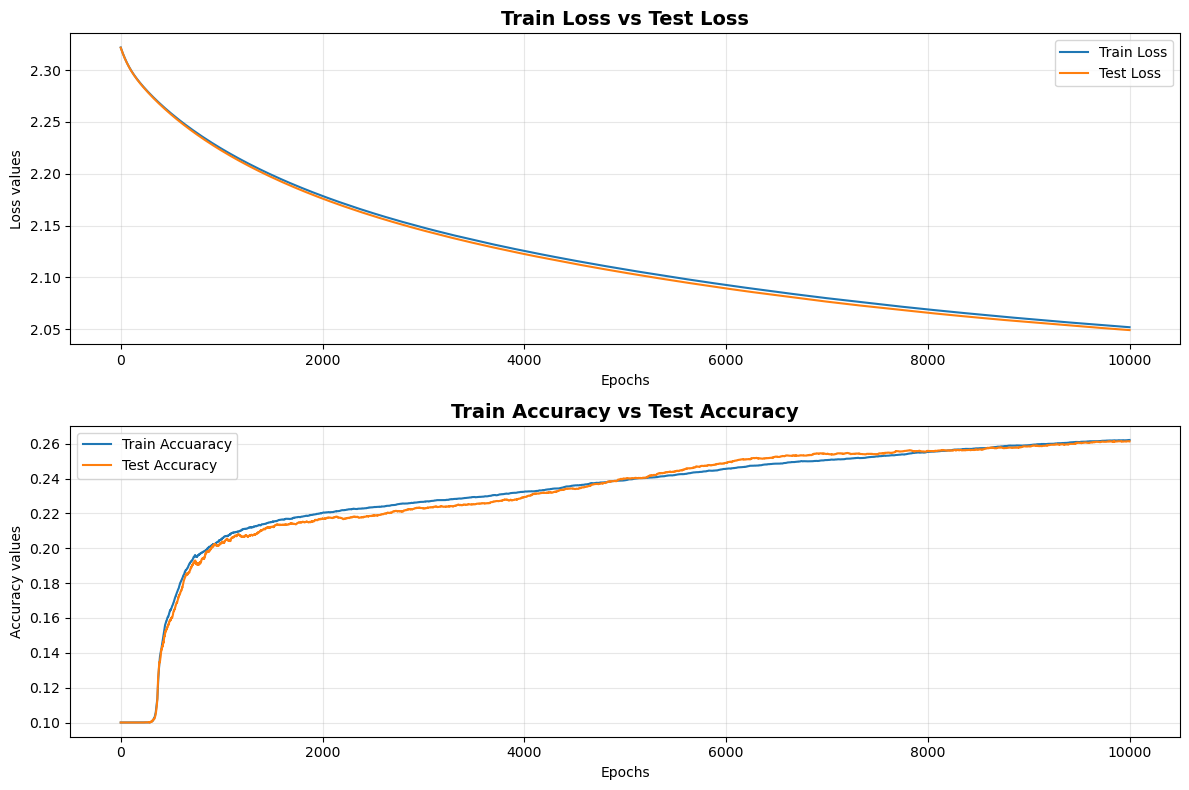

In [160]:
evaluate_model(model0_metrics1,y_test_tensor,test_preds01,class_names)

- model0_2
- number of cluster centers = 30
- learning rate = 0.01

In [161]:
epochs = 10000
number_of_clusters = 30
random_clusters = random_cluster_centers(X_train_pca_tensor.cpu(),y_train_tensor.cpu(),number_of_clusters)
model0_2 = mRBF_network1(random_clusters,len(class_names)).to(device)

model0_metrics2 = my_Metrics(epochs)
test_preds02 = train_test_model(model0_2,X_train_pca_tensor,y_train_tensor,X_test_pca_tensor,y_test_tensor,epochs,model0_metrics2,lr=0.01)

Epoch: 0 | Train Loss: 2.30911, Train Accuracy: 12.17% | Test Loss: 2.30728, Test Accuracy: 12.84%
Epoch: 1000 | Train Loss: 2.08144, Train Accuracy: 26.12% | Test Loss: 2.08089, Test Accuracy: 26.15%
Epoch: 2000 | Train Loss: 2.03874, Train Accuracy: 27.54% | Test Loss: 2.03956, Test Accuracy: 27.17%
Epoch: 3000 | Train Loss: 2.01807, Train Accuracy: 28.22% | Test Loss: 2.02048, Test Accuracy: 28.03%
Epoch: 4000 | Train Loss: 2.00531, Train Accuracy: 28.58% | Test Loss: 2.00926, Test Accuracy: 28.41%
Epoch: 5000 | Train Loss: 1.99594, Train Accuracy: 28.94% | Test Loss: 2.00120, Test Accuracy: 28.70%
Epoch: 6000 | Train Loss: 1.98863, Train Accuracy: 29.14% | Test Loss: 1.99501, Test Accuracy: 28.79%
Epoch: 7000 | Train Loss: 1.98288, Train Accuracy: 29.42% | Test Loss: 1.99027, Test Accuracy: 29.09%
Epoch: 8000 | Train Loss: 1.97831, Train Accuracy: 29.56% | Test Loss: 1.98664, Test Accuracy: 29.25%
Epoch: 9000 | Train Loss: 1.97465, Train Accuracy: 29.68% | Test Loss: 1.98384, Test 

              precision    recall  f1-score   support

    airplane       0.39      0.35      0.37      1000
  automobile       0.29      0.34      0.32      1000
        bird       0.27      0.15      0.19      1000
         cat       0.22      0.11      0.15      1000
        deer       0.31      0.19      0.24      1000
         dog       0.29      0.22      0.25      1000
        frog       0.37      0.33      0.35      1000
       horse       0.27      0.23      0.25      1000
        ship       0.38      0.34      0.36      1000
       truck       0.23      0.66      0.34      1000

    accuracy                           0.29     10000
   macro avg       0.30      0.29      0.28     10000
weighted avg       0.30      0.29      0.28     10000



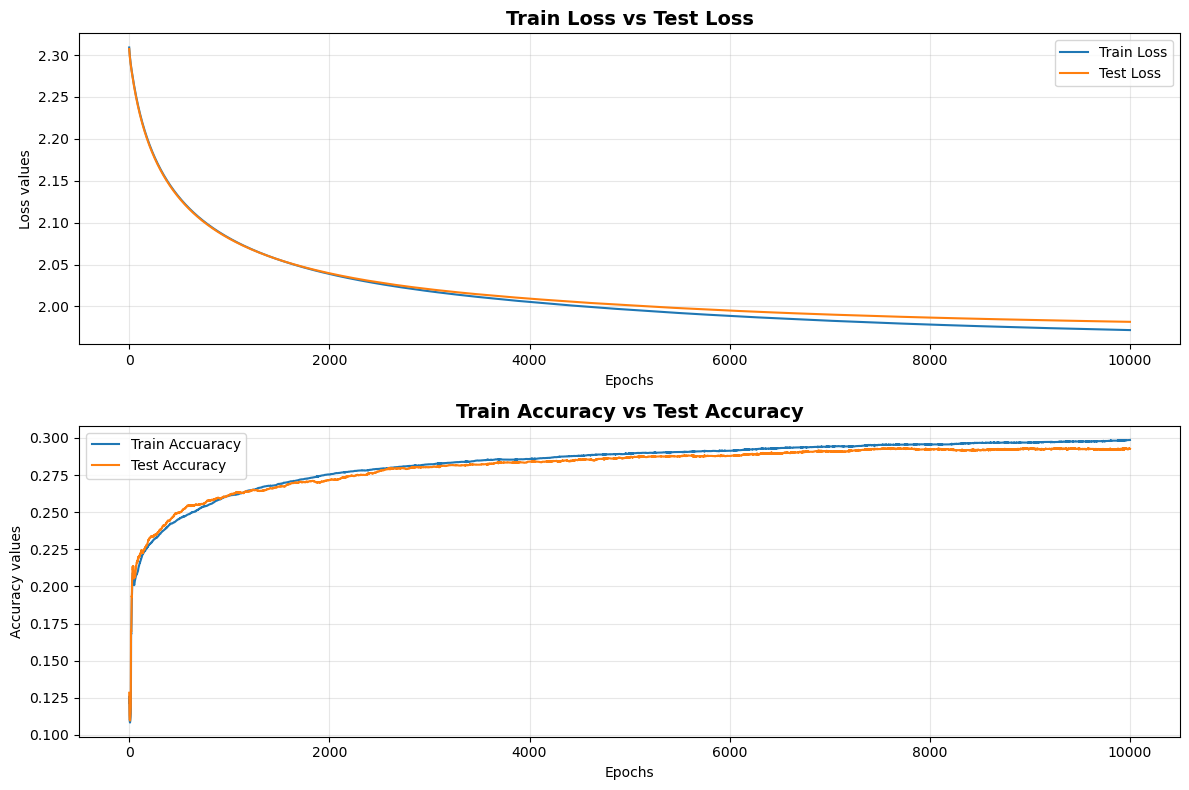

In [162]:
evaluate_model(model0_metrics2,y_test_tensor,test_preds02,class_names)

- model0_3
- number of cluster centers = 20
- learning rate = 0.1

In [163]:
epochs = 10000
number_of_clusters = 20
random_clusters = random_cluster_centers(X_train_pca_tensor.cpu(),y_train_tensor.cpu(),number_of_clusters)
model0_3 = mRBF_network1(random_clusters,len(class_names)).to(device)

model0_metrics3 = my_Metrics(epochs)
test_preds03 = train_test_model(model0_3,X_train_pca_tensor,y_train_tensor,X_test_pca_tensor,y_test_tensor,epochs,model0_metrics3,lr=0.1)

Epoch: 0 | Train Loss: 2.30703, Train Accuracy: 10.32% | Test Loss: 2.29567, Test Accuracy: 16.41%
Epoch: 1000 | Train Loss: 1.97497, Train Accuracy: 28.87% | Test Loss: 1.97845, Test Accuracy: 29.15%
Epoch: 2000 | Train Loss: 1.96562, Train Accuracy: 29.36% | Test Loss: 1.96969, Test Accuracy: 29.36%
Epoch: 3000 | Train Loss: 1.96355, Train Accuracy: 29.39% | Test Loss: 1.96802, Test Accuracy: 29.32%
Epoch: 4000 | Train Loss: 1.96285, Train Accuracy: 29.43% | Test Loss: 1.96752, Test Accuracy: 29.38%
Epoch: 5000 | Train Loss: 1.96255, Train Accuracy: 29.44% | Test Loss: 1.96735, Test Accuracy: 29.51%
Epoch: 6000 | Train Loss: 1.96241, Train Accuracy: 29.47% | Test Loss: 1.96731, Test Accuracy: 29.56%
Epoch: 7000 | Train Loss: 1.96236, Train Accuracy: 29.40% | Test Loss: 1.96736, Test Accuracy: 29.60%
Epoch: 8000 | Train Loss: 1.96233, Train Accuracy: 29.47% | Test Loss: 1.96742, Test Accuracy: 29.54%
Epoch: 9000 | Train Loss: 1.96234, Train Accuracy: 29.54% | Test Loss: 1.96745, Test 

              precision    recall  f1-score   support

    airplane       0.40      0.33      0.36      1000
  automobile       0.26      0.31      0.29      1000
        bird       0.28      0.14      0.19      1000
         cat       0.22      0.11      0.15      1000
        deer       0.31      0.24      0.27      1000
         dog       0.28      0.22      0.25      1000
        frog       0.37      0.35      0.36      1000
       horse       0.26      0.24      0.25      1000
        ship       0.38      0.36      0.37      1000
       truck       0.25      0.64      0.36      1000

    accuracy                           0.30     10000
   macro avg       0.30      0.30      0.28     10000
weighted avg       0.30      0.30      0.28     10000



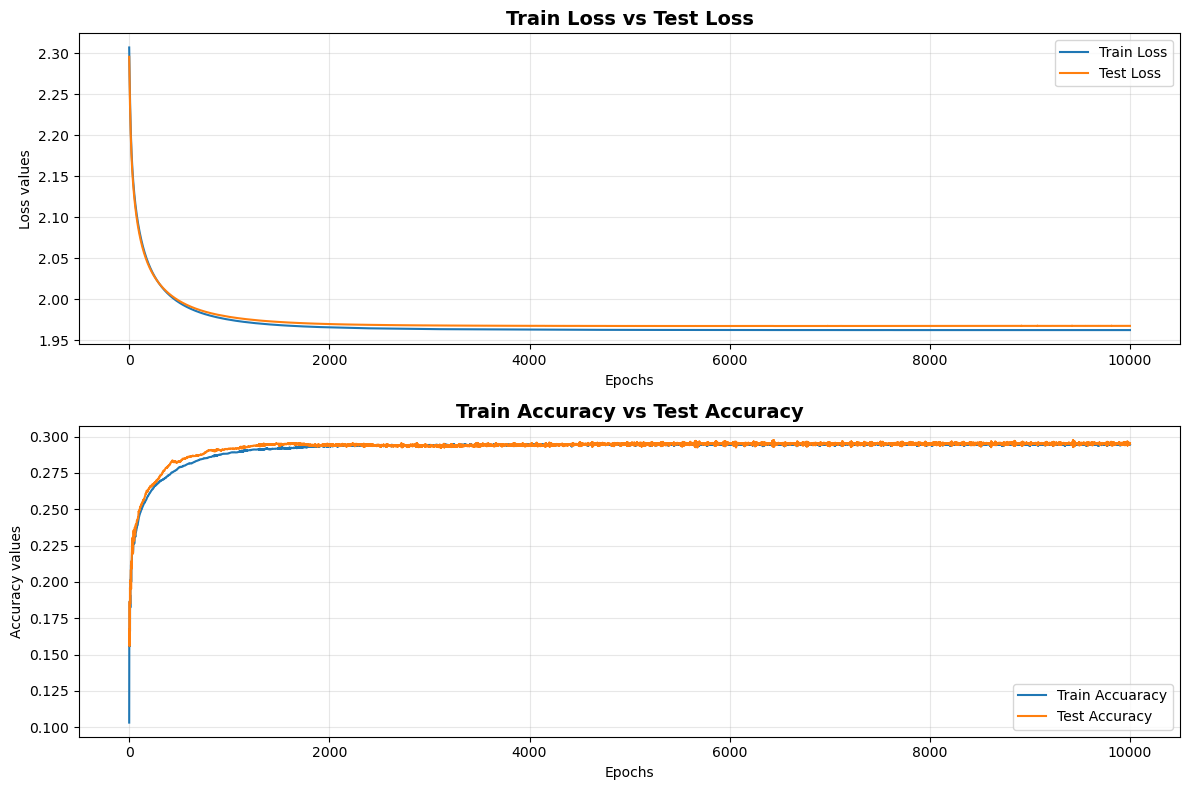

In [164]:
evaluate_model(model0_metrics3,y_test_tensor,test_preds03,class_names)

#### Kmeans for cluster centers

Now i will use the KMeans algorithm to find the cluster centers. 

Again i will expirement with a variety of values for the `n_clusters` and the `lr`

- model1
- number of cluster centers = 10
- learning rate = 0.001

In [165]:
kmeans = KMeans(n_clusters=10, random_state=42).fit(X_train_pca)
clusters = kmeans.cluster_centers_
epochs = 10000
model1 = mRBF_network1(clusters,len(class_names)).to(device)
model1_metrics1 = my_Metrics(epochs)

test_preds11 = train_test_model(model1,X_train_pca_tensor,y_train_tensor,X_test_pca_tensor,y_test_tensor,epochs,model1_metrics1,lr=0.001)    

Epoch: 0 | Train Loss: 2.31026, Train Accuracy: 10.76% | Test Loss: 2.30958, Test Accuracy: 10.72%
Epoch: 1000 | Train Loss: 2.13923, Train Accuracy: 23.01% | Test Loss: 2.13779, Test Accuracy: 23.05%
Epoch: 2000 | Train Loss: 2.07975, Train Accuracy: 24.71% | Test Loss: 2.07786, Test Accuracy: 25.04%
Epoch: 3000 | Train Loss: 2.04944, Train Accuracy: 25.57% | Test Loss: 2.04760, Test Accuracy: 25.83%
Epoch: 4000 | Train Loss: 2.03104, Train Accuracy: 26.06% | Test Loss: 2.02953, Test Accuracy: 26.24%
Epoch: 5000 | Train Loss: 2.01876, Train Accuracy: 26.31% | Test Loss: 2.01771, Test Accuracy: 26.72%
Epoch: 6000 | Train Loss: 2.01031, Train Accuracy: 26.57% | Test Loss: 2.00977, Test Accuracy: 27.06%
Epoch: 7000 | Train Loss: 2.00437, Train Accuracy: 26.77% | Test Loss: 2.00438, Test Accuracy: 27.27%
Epoch: 8000 | Train Loss: 1.99999, Train Accuracy: 26.91% | Test Loss: 2.00053, Test Accuracy: 27.36%
Epoch: 9000 | Train Loss: 1.99657, Train Accuracy: 27.01% | Test Loss: 1.99756, Test 

              precision    recall  f1-score   support

    airplane       0.37      0.33      0.35      1000
  automobile       0.21      0.29      0.24      1000
        bird       0.24      0.12      0.16      1000
         cat       0.14      0.06      0.08      1000
        deer       0.29      0.25      0.27      1000
         dog       0.23      0.23      0.23      1000
        frog       0.30      0.34      0.32      1000
       horse       0.20      0.21      0.21      1000
        ship       0.39      0.42      0.40      1000
       truck       0.29      0.48      0.36      1000

    accuracy                           0.27     10000
   macro avg       0.27      0.27      0.26     10000
weighted avg       0.27      0.27      0.26     10000



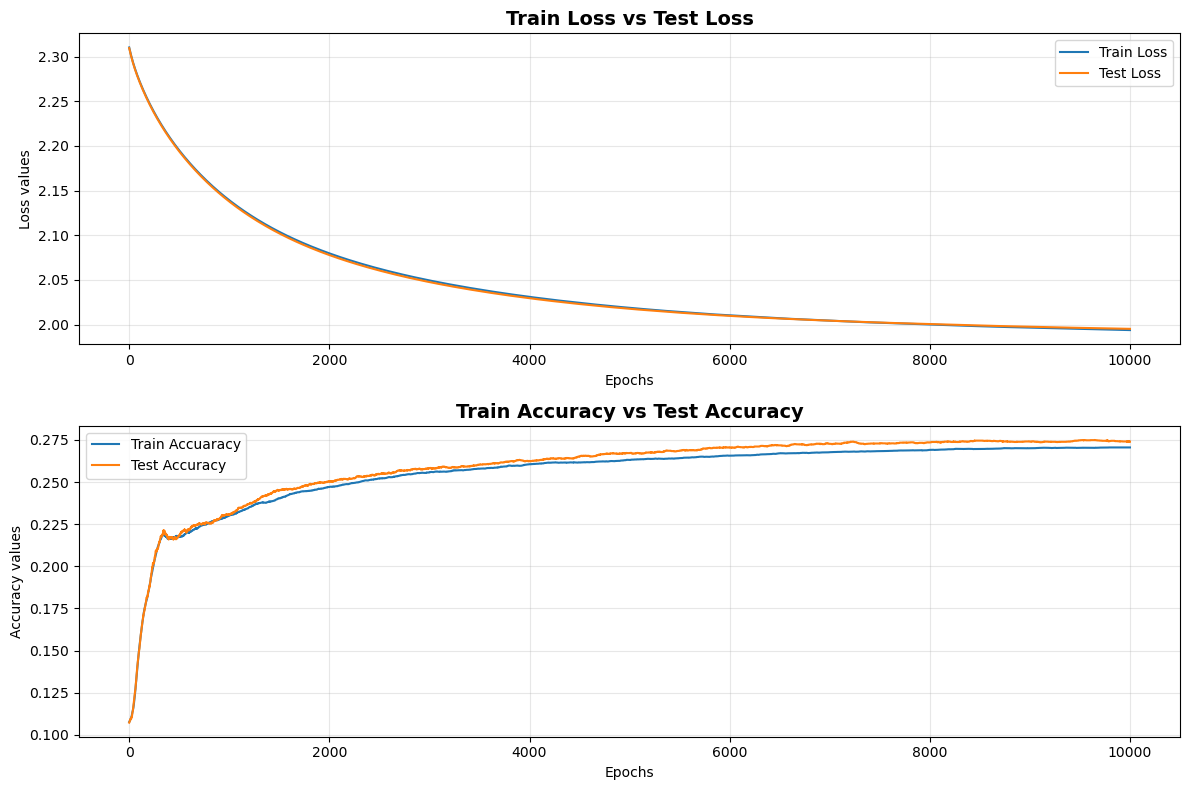

In [166]:
evaluate_model(model1_metrics1,y_test_tensor,test_preds11,class_names)    

- model1_2
- number of cluster centers = 10
- learning rate = 0.01 

In [167]:
epochs = 10000
model1_2 = mRBF_network1(clusters,len(class_names)).to(device)  
model1_metrics2 = my_Metrics(epochs) 

test_preds12 = train_test_model(model1_2,X_train_pca_tensor,y_train_tensor,X_test_pca_tensor,y_test_tensor,5000,model1_metrics2,lr=0.01)

Epoch: 0 | Train Loss: 2.33572, Train Accuracy: 9.18% | Test Loss: 2.32825, Test Accuracy: 9.27%
Epoch: 500 | Train Loss: 2.02794, Train Accuracy: 26.05% | Test Loss: 2.02634, Test Accuracy: 26.33%
Epoch: 1000 | Train Loss: 2.00487, Train Accuracy: 26.74% | Test Loss: 2.00522, Test Accuracy: 27.12%
Epoch: 1500 | Train Loss: 1.99598, Train Accuracy: 26.99% | Test Loss: 1.99752, Test Accuracy: 27.36%
Epoch: 2000 | Train Loss: 1.99104, Train Accuracy: 27.10% | Test Loss: 1.99341, Test Accuracy: 27.49%
Epoch: 2500 | Train Loss: 1.98811, Train Accuracy: 27.16% | Test Loss: 1.99110, Test Accuracy: 27.51%
Epoch: 3000 | Train Loss: 1.98640, Train Accuracy: 27.19% | Test Loss: 1.98986, Test Accuracy: 27.51%
Epoch: 3500 | Train Loss: 1.98546, Train Accuracy: 27.25% | Test Loss: 1.98925, Test Accuracy: 27.54%
Epoch: 4000 | Train Loss: 1.98498, Train Accuracy: 27.27% | Test Loss: 1.98902, Test Accuracy: 27.59%
Epoch: 4500 | Train Loss: 1.98477, Train Accuracy: 27.25% | Test Loss: 1.98899, Test Acc

              precision    recall  f1-score   support

    airplane       0.37      0.32      0.34      1000
  automobile       0.21      0.28      0.24      1000
        bird       0.23      0.13      0.17      1000
         cat       0.14      0.06      0.08      1000
        deer       0.29      0.25      0.27      1000
         dog       0.23      0.22      0.22      1000
        frog       0.32      0.36      0.34      1000
       horse       0.21      0.22      0.22      1000
        ship       0.41      0.44      0.42      1000
       truck       0.29      0.49      0.36      1000

    accuracy                           0.28     10000
   macro avg       0.27      0.28      0.27     10000
weighted avg       0.27      0.28      0.27     10000



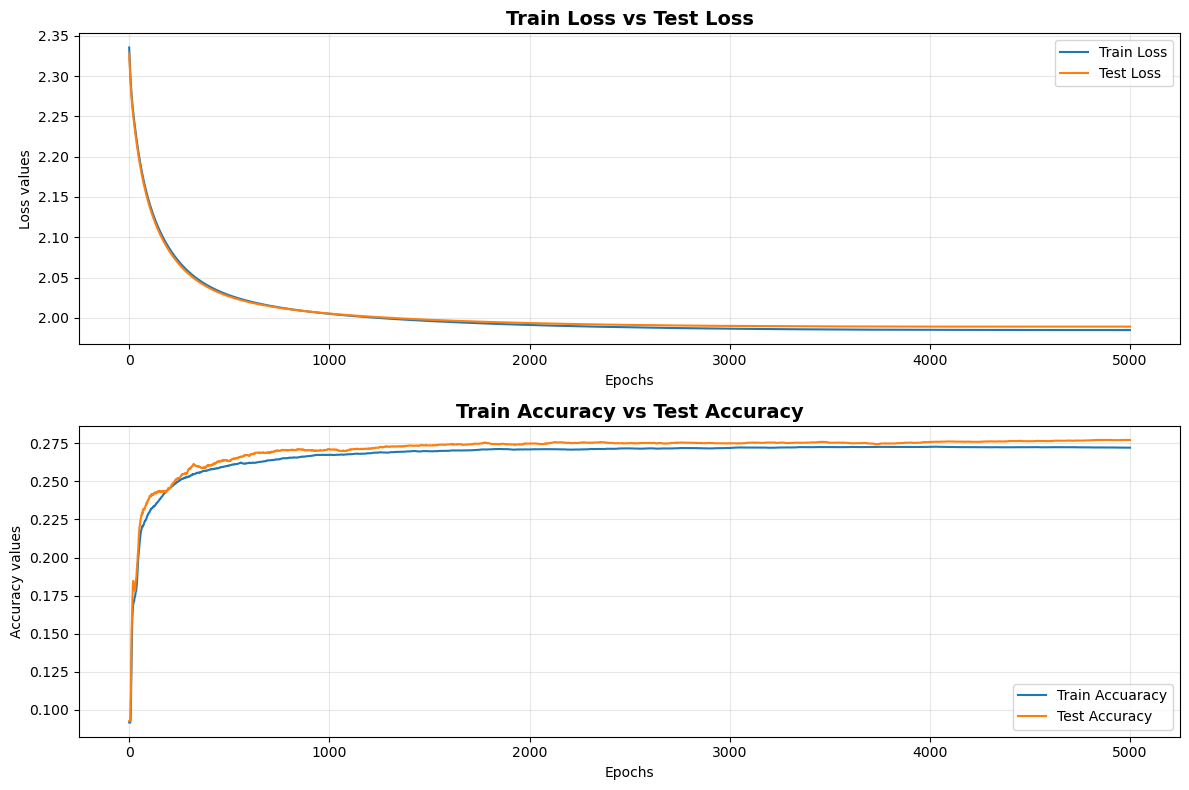

In [168]:
evaluate_model(model1_metrics2,y_test_tensor,test_preds12,class_names)

- model1_3
- number of cluster centers = 30
- learning rate = 0.001

In [169]:
kmeans = KMeans(n_clusters=30, random_state=42).fit(X_train_pca)
clusters = kmeans.cluster_centers_

epochs = 10000
model1_3 = mRBF_network1(clusters,len(class_names)).to(device)
model1_metrics3 = my_Metrics(epochs)

test_preds13 = train_test_model(model1_3,X_train_pca_tensor,y_train_tensor,X_test_pca_tensor,y_test_tensor,epochs,model1_metrics3,lr=0.001)


Epoch: 0 | Train Loss: 2.30639, Train Accuracy: 10.65% | Test Loss: 2.30590, Test Accuracy: 10.74%
Epoch: 1000 | Train Loss: 2.15024, Train Accuracy: 23.86% | Test Loss: 2.14825, Test Accuracy: 23.74%
Epoch: 2000 | Train Loss: 2.09178, Train Accuracy: 25.47% | Test Loss: 2.09024, Test Accuracy: 25.60%
Epoch: 3000 | Train Loss: 2.05676, Train Accuracy: 26.58% | Test Loss: 2.05621, Test Accuracy: 26.95%
Epoch: 4000 | Train Loss: 2.03231, Train Accuracy: 27.50% | Test Loss: 2.03302, Test Accuracy: 27.57%
Epoch: 5000 | Train Loss: 2.01386, Train Accuracy: 28.02% | Test Loss: 2.01601, Test Accuracy: 28.36%
Epoch: 6000 | Train Loss: 1.99920, Train Accuracy: 28.54% | Test Loss: 2.00286, Test Accuracy: 29.01%
Epoch: 7000 | Train Loss: 1.98713, Train Accuracy: 28.90% | Test Loss: 1.99219, Test Accuracy: 29.49%
Epoch: 8000 | Train Loss: 1.97695, Train Accuracy: 29.27% | Test Loss: 1.98319, Test Accuracy: 29.75%
Epoch: 9000 | Train Loss: 1.96830, Train Accuracy: 29.65% | Test Loss: 1.97550, Test 

              precision    recall  f1-score   support

    airplane       0.49      0.32      0.39      1000
  automobile       0.21      0.52      0.30      1000
        bird       0.27      0.14      0.19      1000
         cat       0.22      0.13      0.16      1000
        deer       0.34      0.24      0.28      1000
         dog       0.28      0.23      0.25      1000
        frog       0.37      0.33      0.35      1000
       horse       0.28      0.23      0.25      1000
        ship       0.43      0.40      0.42      1000
       truck       0.32      0.48      0.38      1000

    accuracy                           0.30     10000
   macro avg       0.32      0.30      0.30     10000
weighted avg       0.32      0.30      0.30     10000



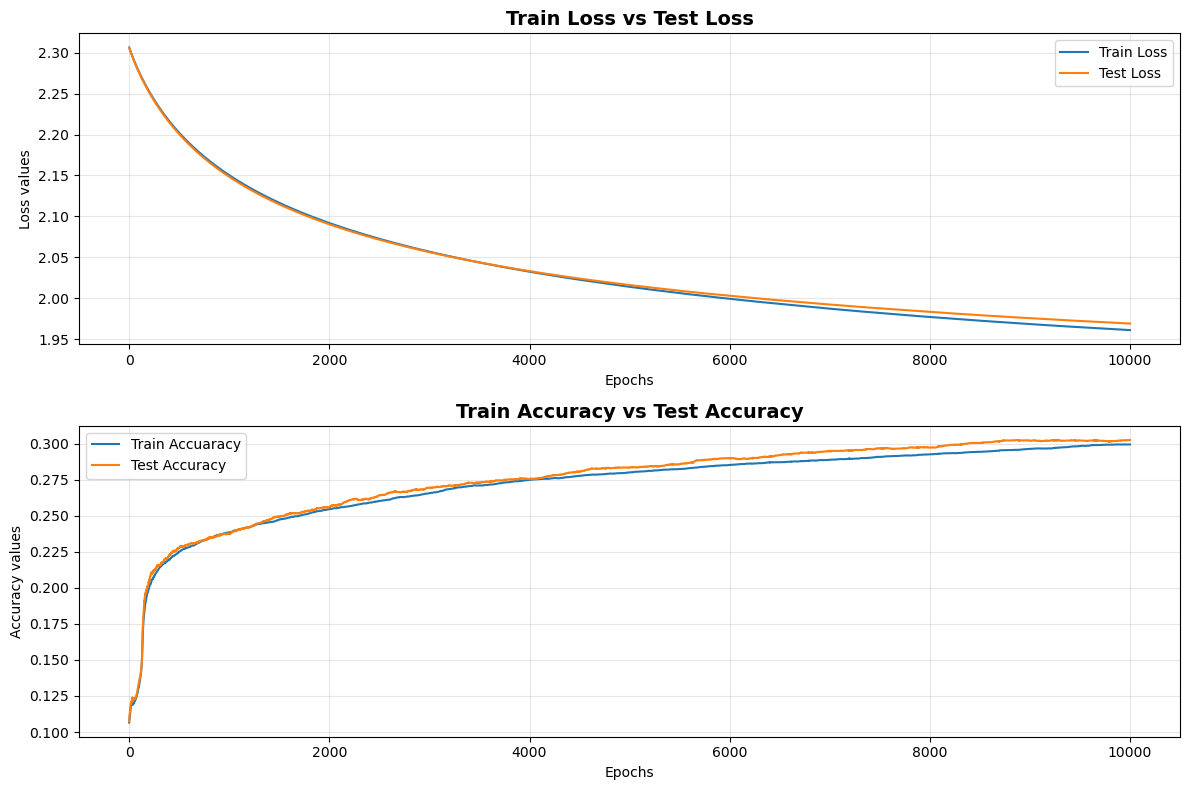

In [170]:
evaluate_model(model1_metrics3,y_test_tensor,test_preds13,class_names)

- model1_4
- number of cluster centers = 20
- learning rate = 0.1

In [171]:
kmeans = KMeans(n_clusters=20, random_state=42).fit(X_train_pca)
clusters = kmeans.cluster_centers_

epochs = 10000
model1_4 = mRBF_network1(clusters,len(class_names)).to(device)
model1_metrics4 = my_Metrics(epochs)

test_preds14 = train_test_model(model1_4,X_train_pca_tensor,y_train_tensor,X_test_pca_tensor,y_test_tensor,epochs,model1_metrics4,lr=0.1)

Epoch: 0 | Train Loss: 2.30469, Train Accuracy: 8.62% | Test Loss: 2.27335, Test Accuracy: 12.65%
Epoch: 1000 | Train Loss: 1.93873, Train Accuracy: 30.24% | Test Loss: 1.94498, Test Accuracy: 30.47%
Epoch: 2000 | Train Loss: 1.93870, Train Accuracy: 30.24% | Test Loss: 1.94498, Test Accuracy: 30.42%
Epoch: 3000 | Train Loss: 1.93870, Train Accuracy: 30.22% | Test Loss: 1.94503, Test Accuracy: 30.50%
Epoch: 4000 | Train Loss: 1.93874, Train Accuracy: 30.23% | Test Loss: 1.94510, Test Accuracy: 30.42%
Epoch: 5000 | Train Loss: 1.93870, Train Accuracy: 30.23% | Test Loss: 1.94504, Test Accuracy: 30.49%
Epoch: 6000 | Train Loss: 1.93875, Train Accuracy: 30.27% | Test Loss: 1.94503, Test Accuracy: 30.45%
Epoch: 7000 | Train Loss: 1.93872, Train Accuracy: 30.25% | Test Loss: 1.94496, Test Accuracy: 30.53%
Epoch: 8000 | Train Loss: 1.93870, Train Accuracy: 30.23% | Test Loss: 1.94501, Test Accuracy: 30.50%
Epoch: 9000 | Train Loss: 1.93870, Train Accuracy: 30.22% | Test Loss: 1.94507, Test A

              precision    recall  f1-score   support

    airplane       0.45      0.36      0.40      1000
  automobile       0.24      0.35      0.29      1000
        bird       0.27      0.15      0.20      1000
         cat       0.23      0.15      0.18      1000
        deer       0.34      0.25      0.29      1000
         dog       0.27      0.27      0.27      1000
        frog       0.33      0.34      0.33      1000
       horse       0.24      0.20      0.22      1000
        ship       0.44      0.42      0.43      1000
       truck       0.28      0.56      0.37      1000

    accuracy                           0.30     10000
   macro avg       0.31      0.30      0.30     10000
weighted avg       0.31      0.30      0.30     10000



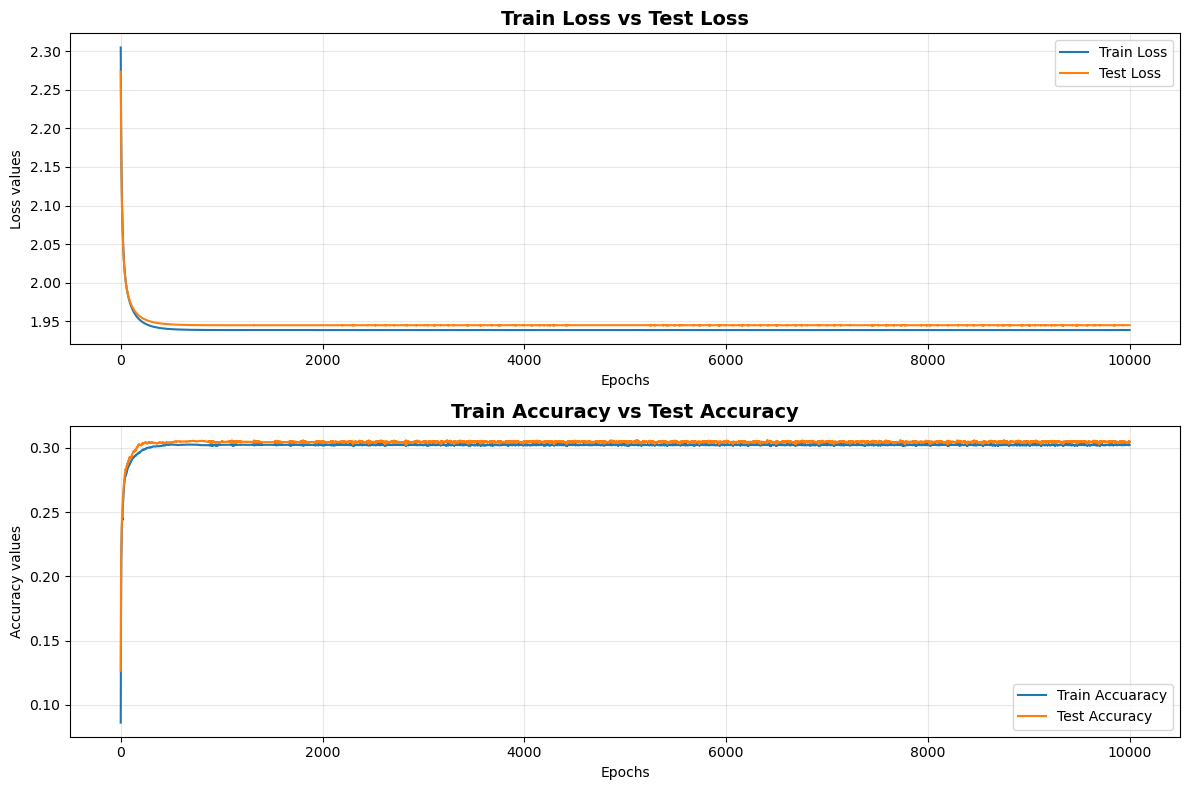

In [172]:
evaluate_model(model1_metrics4,y_test_tensor,test_preds14,class_names)  

- Plot the accuracy curves for the RBF NN(v1) models

From the following graph, i can say that, when i use the kmeans algorithm to find the cluster centers, my model performs better than when i randomly select the cluster centers. 

Also i notice that increasing the number of clusters might improve the accuracy up to a certain point.

The best model is `model1_4` that uses the kmeans algorithm for 20 cluster centers. It achieves 30.45% accuracy for 10000 epochs





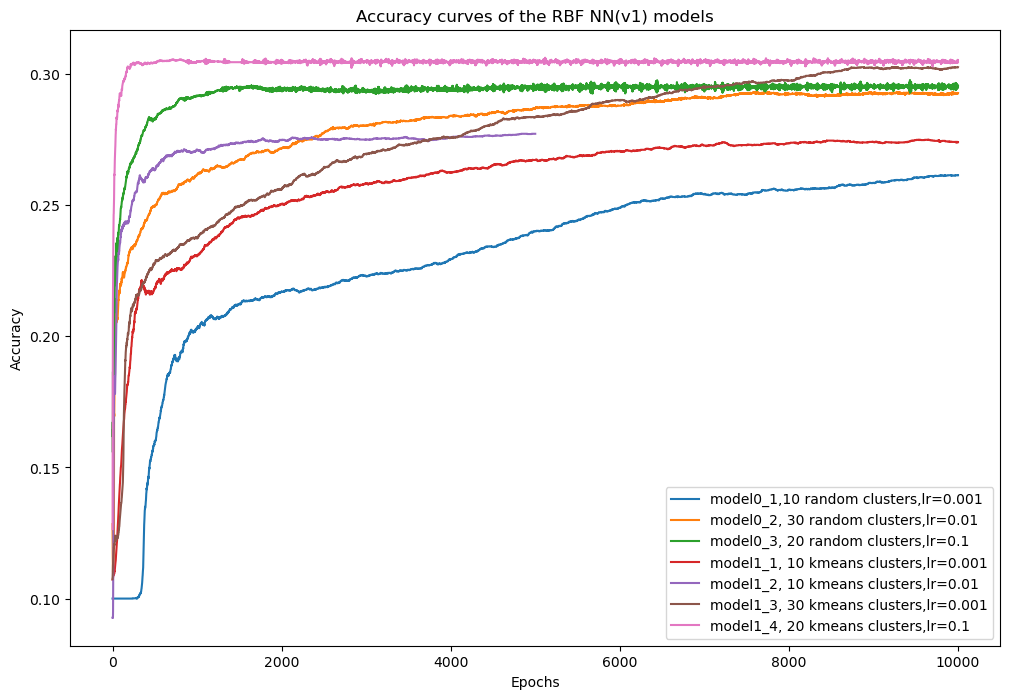

In [173]:

plt.figure(figsize=(12, 8))
plt.plot(model0_metrics1.test_acc_values,label="model0_1,10 random clusters,lr=0.001");
plt.plot(model0_metrics2.test_acc_values,label="model0_2, 30 random clusters,lr=0.01");
plt.plot(model0_metrics3.test_acc_values,label="model0_3, 20 random clusters,lr=0.1");
plt.plot(model1_metrics1.test_acc_values,label="model1_1, 10 kmeans clusters,lr=0.001");
plt.plot(model1_metrics2.test_acc_values,label="model1_2, 10 kmeans clusters,lr=0.01");
plt.plot(model1_metrics3.test_acc_values,label="model1_3, 30 kmeans clusters,lr=0.001");
plt.plot(model1_metrics4.test_acc_values,label="model1_4, 20 kmeans clusters,lr=0.1");

plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy curves of the RBF NN(v1) models")
plt.legend();




### 2.5 Create RBF Neural Network (v2)

The difference between this RBF NN and the previous one, is that now the clusters and the σ are not fixed, but they are being trained like the weights and biases of the linear layer and therefore i am expecting higher accuracy. 

The procedure remains the same as in `mRBF_network1`.

In [174]:
class mRBF_network2(nn.Module):
    def __init__(self, clusters, num_outputs):
        super().__init__()
        # Initialize cluster centers as trainable parameters
        self.clusters = nn.Parameter(torch.from_numpy(clusters).to(device).float())
        self.n_clusters = clusters.shape[0]
        self.num_outputs = num_outputs

        # Initialize sigma as a trainable parameter
        pairwise_distances = torch.cdist(self.clusters, self.clusters, p=2)
        dmax = torch.max(pairwise_distances)
        self.sigma = nn.Parameter(dmax / torch.sqrt(2.0 * torch.tensor(self.n_clusters, dtype=torch.float32)))

        # Linear output layer
        self.rbf_layer = nn.Linear(self.n_clusters, self.num_outputs)

    def forward(self, X):
        # Calculate RBF activations
        rbf_outputs = torch.exp(-torch.cdist(X, self.clusters, p=2) ** 2 / (2 * self.sigma ** 2))
        # Pass through the linear output layer
        return self.rbf_layer(rbf_outputs)


#### Random Cluster Centers

I will experiment with a variety of values for the number of cluster centers and the learning rate

- model2_r1
- number of cluster centers = 10
- learning rate = 0.01

In [175]:
random_clusters = random_cluster_centers(X_train_pca_tensor.cpu(),y_train_tensor.cpu(),10)
epochs = 10000
model2_r1 = mRBF_network2(random_clusters,len(class_names)).to(device)
model2_r1_metrics = my_Metrics(epochs)

test_preds2_r1 = train_test_model(model2_r1,X_train_pca_tensor,y_train_tensor,X_test_pca_tensor,y_test_tensor,epochs,model2_r1_metrics,lr=0.01)

Epoch: 0 | Train Loss: 2.32242, Train Accuracy: 10.00% | Test Loss: 2.31981, Test Accuracy: 10.00%
Epoch: 1000 | Train Loss: 1.77711, Train Accuracy: 36.58% | Test Loss: 1.78027, Test Accuracy: 37.08%
Epoch: 2000 | Train Loss: 1.67387, Train Accuracy: 40.43% | Test Loss: 1.67936, Test Accuracy: 40.46%
Epoch: 3000 | Train Loss: 1.63314, Train Accuracy: 42.18% | Test Loss: 1.64206, Test Accuracy: 41.47%
Epoch: 4000 | Train Loss: 1.61321, Train Accuracy: 42.86% | Test Loss: 1.62571, Test Accuracy: 42.04%
Epoch: 5000 | Train Loss: 1.60359, Train Accuracy: 43.10% | Test Loss: 1.61899, Test Accuracy: 42.37%
Epoch: 6000 | Train Loss: 1.59807, Train Accuracy: 43.34% | Test Loss: 1.61590, Test Accuracy: 42.29%
Epoch: 7000 | Train Loss: 1.59454, Train Accuracy: 43.50% | Test Loss: 1.61434, Test Accuracy: 42.41%
Epoch: 8000 | Train Loss: 1.59204, Train Accuracy: 43.61% | Test Loss: 1.61329, Test Accuracy: 42.53%
Epoch: 9000 | Train Loss: 1.59016, Train Accuracy: 43.71% | Test Loss: 1.61254, Test 

              precision    recall  f1-score   support

    airplane       0.49      0.49      0.49      1000
  automobile       0.47      0.52      0.50      1000
        bird       0.31      0.27      0.29      1000
         cat       0.30      0.22      0.25      1000
        deer       0.37      0.31      0.34      1000
         dog       0.38      0.34      0.36      1000
        frog       0.43      0.56      0.48      1000
       horse       0.44      0.47      0.45      1000
        ship       0.52      0.59      0.56      1000
       truck       0.45      0.48      0.47      1000

    accuracy                           0.43     10000
   macro avg       0.42      0.43      0.42     10000
weighted avg       0.42      0.43      0.42     10000



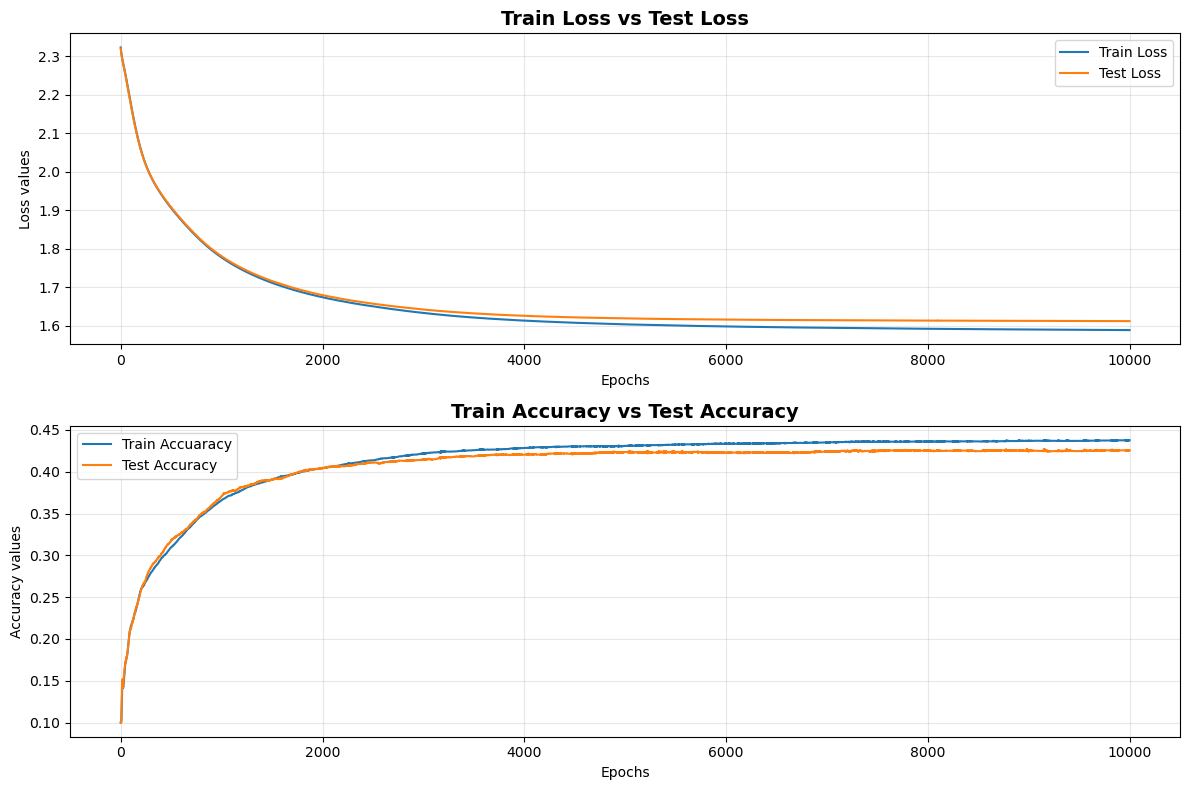

In [176]:
evaluate_model(model2_r1_metrics,y_test_tensor,test_preds2_r1,class_names)

- model2_r2
- number of cluster centers = 10
- learning rate = 0.1

In [177]:
model2_r2 = mRBF_network2(random_clusters,len(class_names)).to(device)
model2_r2_metrics = my_Metrics(epochs)

test_preds2_r2 = train_test_model(model2_r2,X_train_pca_tensor,y_train_tensor,X_test_pca_tensor,y_test_tensor,epochs,model2_r2_metrics,lr=0.1)

Epoch: 0 | Train Loss: 2.31657, Train Accuracy: 10.18% | Test Loss: 2.29513, Test Accuracy: 14.15%
Epoch: 1000 | Train Loss: 1.62120, Train Accuracy: 42.81% | Test Loss: 1.63029, Test Accuracy: 41.69%
Epoch: 2000 | Train Loss: 1.60592, Train Accuracy: 43.36% | Test Loss: 1.62230, Test Accuracy: 42.30%
Epoch: 3000 | Train Loss: 1.59922, Train Accuracy: 43.65% | Test Loss: 1.61865, Test Accuracy: 42.35%
Epoch: 4000 | Train Loss: 1.59582, Train Accuracy: 43.81% | Test Loss: 1.61684, Test Accuracy: 42.69%
Epoch: 5000 | Train Loss: 1.59310, Train Accuracy: 43.92% | Test Loss: 1.61552, Test Accuracy: 42.70%
Epoch: 6000 | Train Loss: 1.59101, Train Accuracy: 43.98% | Test Loss: 1.61466, Test Accuracy: 42.71%
Epoch: 7000 | Train Loss: 1.58950, Train Accuracy: 44.06% | Test Loss: 1.61369, Test Accuracy: 42.83%
Epoch: 8000 | Train Loss: 1.58837, Train Accuracy: 44.08% | Test Loss: 1.61307, Test Accuracy: 42.75%
Epoch: 9000 | Train Loss: 1.58746, Train Accuracy: 44.13% | Test Loss: 1.61254, Test 

              precision    recall  f1-score   support

    airplane       0.49      0.47      0.48      1000
  automobile       0.47      0.54      0.50      1000
        bird       0.30      0.25      0.28      1000
         cat       0.30      0.22      0.26      1000
        deer       0.39      0.36      0.38      1000
         dog       0.40      0.32      0.36      1000
        frog       0.44      0.56      0.49      1000
       horse       0.45      0.49      0.47      1000
        ship       0.52      0.59      0.55      1000
       truck       0.46      0.48      0.47      1000

    accuracy                           0.43     10000
   macro avg       0.42      0.43      0.42     10000
weighted avg       0.42      0.43      0.42     10000



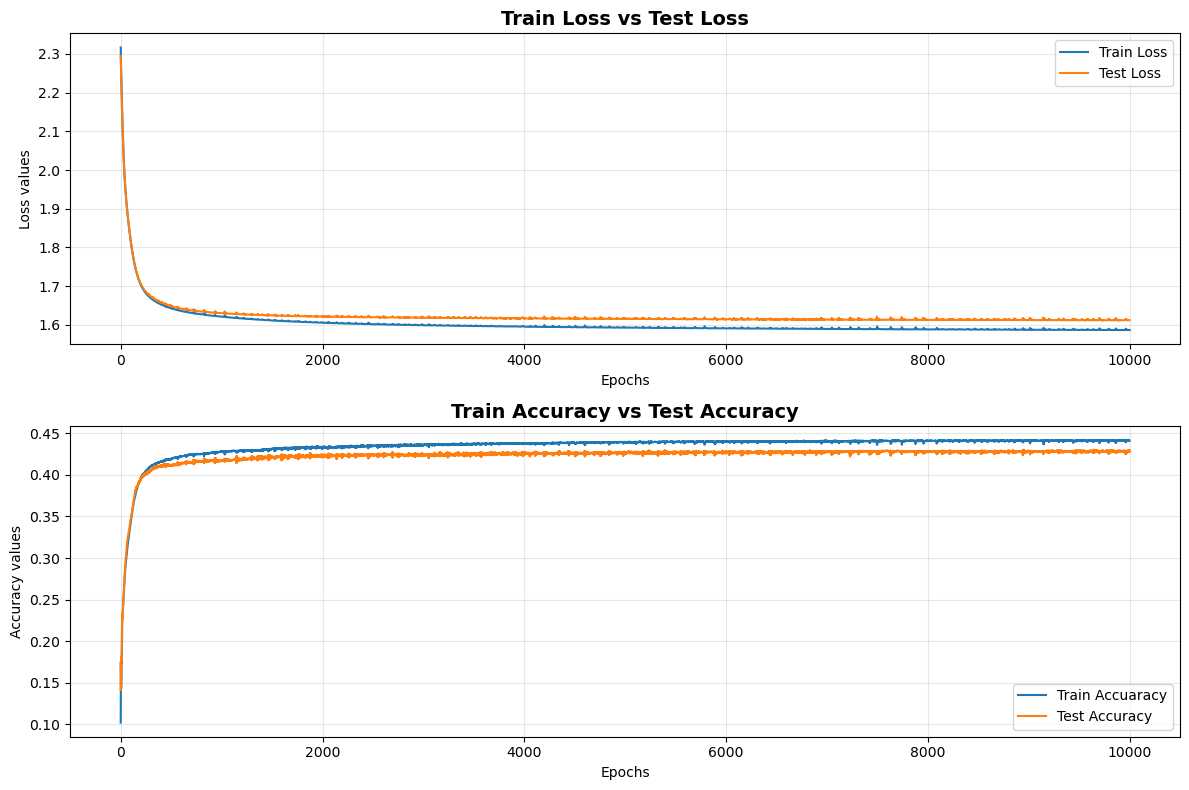

In [178]:
evaluate_model(model2_r2_metrics,y_test_tensor,test_preds2_r2,class_names)

- model2_r3
- number of cluster centers = 30
- learning rate = 0.01

In [179]:
random_clusters = random_cluster_centers(X_train_pca_tensor.cpu(),y_train_tensor.cpu(),30)
epochs = 10000
model2_r3 = mRBF_network2(random_clusters,len(class_names)).to(device)
model2_r3_metrics = my_Metrics(epochs)

test_preds2_r3 = train_test_model(model2_r3,X_train_pca_tensor,y_train_tensor,X_test_pca_tensor,y_test_tensor,epochs,model2_r3_metrics,lr=0.01)

Epoch: 0 | Train Loss: 2.30714, Train Accuracy: 10.00% | Test Loss: 2.30514, Test Accuracy: 10.00%
Epoch: 1000 | Train Loss: 1.61221, Train Accuracy: 43.12% | Test Loss: 1.62436, Test Accuracy: 42.72%
Epoch: 2000 | Train Loss: 1.48896, Train Accuracy: 47.79% | Test Loss: 1.52206, Test Accuracy: 46.12%
Epoch: 3000 | Train Loss: 1.44832, Train Accuracy: 49.25% | Test Loss: 1.49161, Test Accuracy: 47.21%
Epoch: 4000 | Train Loss: 1.42806, Train Accuracy: 49.84% | Test Loss: 1.47726, Test Accuracy: 47.73%
Epoch: 5000 | Train Loss: 1.41562, Train Accuracy: 50.33% | Test Loss: 1.46898, Test Accuracy: 48.08%
Epoch: 6000 | Train Loss: 1.40704, Train Accuracy: 50.51% | Test Loss: 1.46397, Test Accuracy: 48.20%
Epoch: 7000 | Train Loss: 1.40073, Train Accuracy: 50.75% | Test Loss: 1.46062, Test Accuracy: 48.31%
Epoch: 8000 | Train Loss: 1.39581, Train Accuracy: 50.83% | Test Loss: 1.45815, Test Accuracy: 48.47%
Epoch: 9000 | Train Loss: 1.39169, Train Accuracy: 50.98% | Test Loss: 1.45614, Test 

              precision    recall  f1-score   support

    airplane       0.55      0.56      0.55      1000
  automobile       0.57      0.60      0.58      1000
        bird       0.38      0.34      0.36      1000
         cat       0.35      0.30      0.32      1000
        deer       0.41      0.37      0.39      1000
         dog       0.43      0.38      0.40      1000
        frog       0.48      0.60      0.54      1000
       horse       0.54      0.53      0.54      1000
        ship       0.57      0.65      0.61      1000
       truck       0.51      0.55      0.53      1000

    accuracy                           0.49     10000
   macro avg       0.48      0.49      0.48     10000
weighted avg       0.48      0.49      0.48     10000



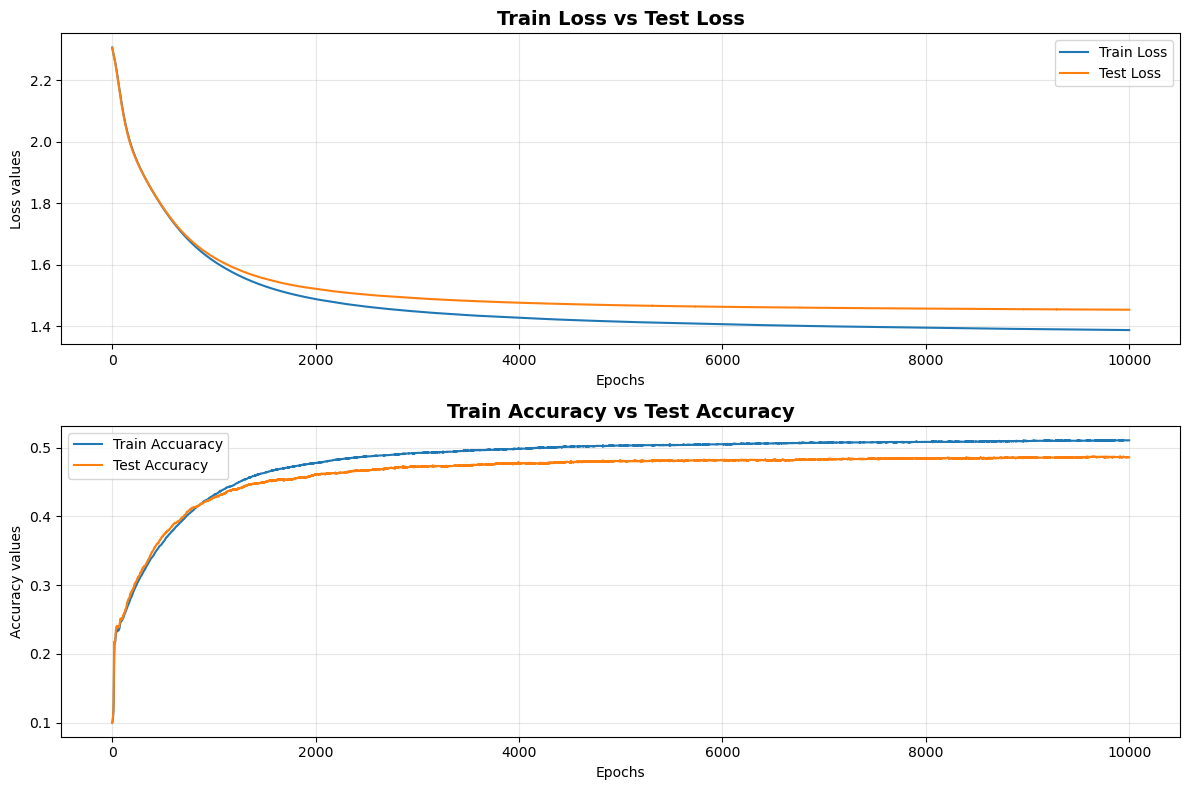

In [180]:
evaluate_model(model2_r3_metrics,y_test_tensor,test_preds2_r3,class_names)

- model2_r4
- number of cluster centers = 20
- learning rate = 0.1

In [181]:
random_clusters = random_cluster_centers(X_train_pca_tensor.cpu(),y_train_tensor.cpu(),20)
epochs = 10000
model2_r4 = mRBF_network2(random_clusters,len(class_names)).to(device)
model2_r4_metrics = my_Metrics(epochs)

test_preds2_r4 = train_test_model(model2_r4,X_train_pca_tensor,y_train_tensor,X_test_pca_tensor,y_test_tensor,epochs,model2_r4_metrics,lr=0.1)

Epoch: 0 | Train Loss: 2.30882, Train Accuracy: 7.02% | Test Loss: 2.29960, Test Accuracy: 12.46%
Epoch: 1000 | Train Loss: 1.50020, Train Accuracy: 47.26% | Test Loss: 1.53258, Test Accuracy: 46.19%
Epoch: 2000 | Train Loss: 1.48179, Train Accuracy: 48.01% | Test Loss: 1.51879, Test Accuracy: 46.63%
Epoch: 3000 | Train Loss: 1.47253, Train Accuracy: 48.31% | Test Loss: 1.51237, Test Accuracy: 46.89%
Epoch: 4000 | Train Loss: 1.46699, Train Accuracy: 48.47% | Test Loss: 1.50882, Test Accuracy: 46.99%
Epoch: 5000 | Train Loss: 1.46356, Train Accuracy: 48.54% | Test Loss: 1.50818, Test Accuracy: 46.96%
Epoch: 6000 | Train Loss: 1.45888, Train Accuracy: 48.70% | Test Loss: 1.50404, Test Accuracy: 46.94%
Epoch: 7000 | Train Loss: 1.45576, Train Accuracy: 48.75% | Test Loss: 1.50218, Test Accuracy: 47.15%
Epoch: 8000 | Train Loss: 1.45350, Train Accuracy: 48.79% | Test Loss: 1.50081, Test Accuracy: 47.21%
Epoch: 9000 | Train Loss: 1.45497, Train Accuracy: 48.78% | Test Loss: 1.50301, Test A

              precision    recall  f1-score   support

    airplane       0.53      0.52      0.53      1000
  automobile       0.58      0.54      0.56      1000
        bird       0.35      0.37      0.36      1000
         cat       0.33      0.31      0.32      1000
        deer       0.42      0.31      0.36      1000
         dog       0.39      0.37      0.38      1000
        frog       0.48      0.59      0.53      1000
       horse       0.51      0.54      0.53      1000
        ship       0.57      0.61      0.59      1000
       truck       0.51      0.52      0.52      1000

    accuracy                           0.47     10000
   macro avg       0.47      0.47      0.47     10000
weighted avg       0.47      0.47      0.47     10000



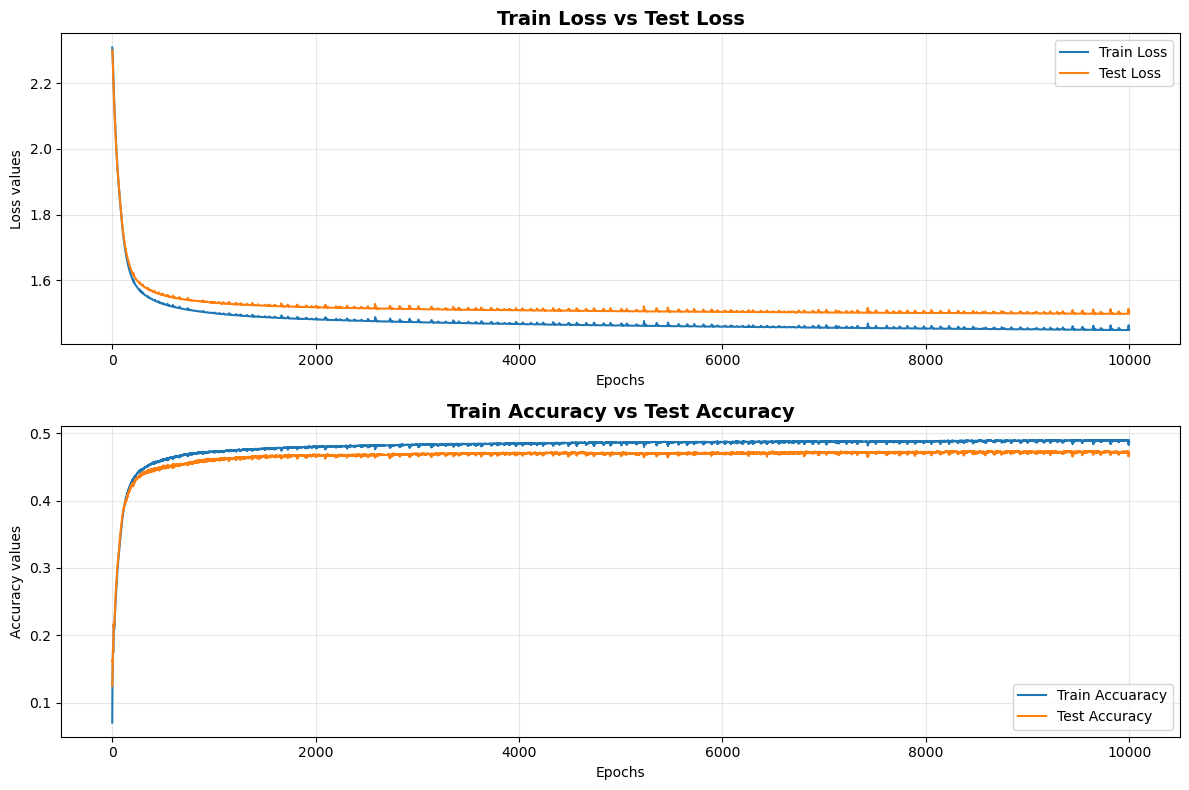

In [182]:
evaluate_model(model2_r4_metrics,y_test_tensor,test_preds2_r4,class_names)

#### Kmeans for cluster centers

Now i will use the KMeans algorithm to find the cluster centers. 

Again i will expirement with a variety of values for the `n_clusters` and the `lr`

- model2
- number of cluster centers = 10
- learning rate = 0.001

In [183]:
kmeans = KMeans(n_clusters=10, random_state=42).fit(X_train_pca)
clusters = kmeans.cluster_centers_
epochs = 10000
model2 = mRBF_network2(clusters, len(class_names)).to(device)
model2_metrics1 = my_Metrics(epochs)

test_preds21 = train_test_model(model2,X_train_pca_tensor,y_train_tensor,X_test_pca_tensor,y_test_tensor,epochs,model2_metrics1,lr=0.001)

Epoch: 0 | Train Loss: 2.31121, Train Accuracy: 9.36% | Test Loss: 2.31105, Test Accuracy: 9.36%
Epoch: 1000 | Train Loss: 2.11059, Train Accuracy: 24.68% | Test Loss: 2.10990, Test Accuracy: 24.61%
Epoch: 2000 | Train Loss: 2.02328, Train Accuracy: 26.75% | Test Loss: 2.02258, Test Accuracy: 26.92%
Epoch: 3000 | Train Loss: 1.96867, Train Accuracy: 28.43% | Test Loss: 1.96898, Test Accuracy: 28.46%
Epoch: 4000 | Train Loss: 1.92401, Train Accuracy: 29.84% | Test Loss: 1.92573, Test Accuracy: 30.18%
Epoch: 5000 | Train Loss: 1.88268, Train Accuracy: 31.32% | Test Loss: 1.88509, Test Accuracy: 31.40%
Epoch: 6000 | Train Loss: 1.84312, Train Accuracy: 32.93% | Test Loss: 1.84558, Test Accuracy: 33.03%
Epoch: 7000 | Train Loss: 1.80727, Train Accuracy: 34.49% | Test Loss: 1.80960, Test Accuracy: 34.77%
Epoch: 8000 | Train Loss: 1.77750, Train Accuracy: 35.82% | Test Loss: 1.77965, Test Accuracy: 35.94%
Epoch: 9000 | Train Loss: 1.75339, Train Accuracy: 36.74% | Test Loss: 1.75539, Test Ac

              precision    recall  f1-score   support

    airplane       0.45      0.43      0.44      1000
  automobile       0.38      0.47      0.42      1000
        bird       0.29      0.24      0.27      1000
         cat       0.24      0.13      0.17      1000
        deer       0.34      0.26      0.29      1000
         dog       0.33      0.38      0.35      1000
        frog       0.39      0.48      0.43      1000
       horse       0.40      0.40      0.40      1000
        ship       0.44      0.50      0.47      1000
       truck       0.41      0.47      0.44      1000

    accuracy                           0.38     10000
   macro avg       0.37      0.38      0.37     10000
weighted avg       0.37      0.38      0.37     10000



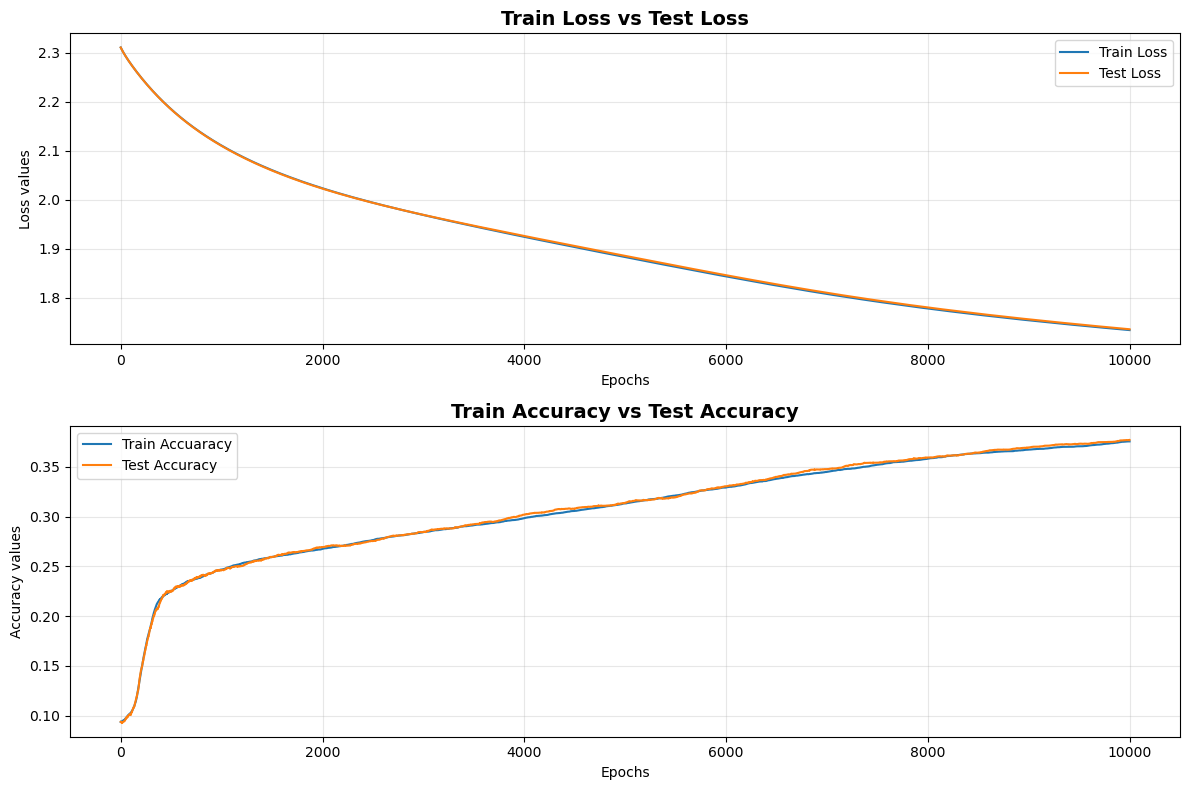

In [184]:
evaluate_model(model2_metrics1,y_test_tensor,test_preds21,class_names)

- model2_2
- number of cluster centers = 10
- learning rate = 0.01


In [185]:
epochs = 10000
model2_2 = mRBF_network2(clusters, len(class_names)).to(device)
model2_metrics2 = my_Metrics(epochs)
test_preds22 = train_test_model(model2_2,X_train_pca_tensor,y_train_tensor,X_test_pca_tensor,y_test_tensor,epochs,model2_metrics2,lr=0.01)


Epoch: 0 | Train Loss: 2.33024, Train Accuracy: 9.99% | Test Loss: 2.32511, Test Accuracy: 9.36%
Epoch: 1000 | Train Loss: 1.76573, Train Accuracy: 36.38% | Test Loss: 1.76592, Test Accuracy: 36.71%
Epoch: 2000 | Train Loss: 1.67298, Train Accuracy: 40.20% | Test Loss: 1.66961, Test Accuracy: 40.44%
Epoch: 3000 | Train Loss: 1.63897, Train Accuracy: 41.50% | Test Loss: 1.63645, Test Accuracy: 41.47%
Epoch: 4000 | Train Loss: 1.62062, Train Accuracy: 42.13% | Test Loss: 1.62115, Test Accuracy: 42.34%
Epoch: 5000 | Train Loss: 1.60970, Train Accuracy: 42.68% | Test Loss: 1.61367, Test Accuracy: 42.32%
Epoch: 6000 | Train Loss: 1.60264, Train Accuracy: 43.05% | Test Loss: 1.60952, Test Accuracy: 42.69%
Epoch: 7000 | Train Loss: 1.59774, Train Accuracy: 43.32% | Test Loss: 1.60670, Test Accuracy: 42.74%
Epoch: 8000 | Train Loss: 1.59424, Train Accuracy: 43.45% | Test Loss: 1.60449, Test Accuracy: 42.88%
Epoch: 9000 | Train Loss: 1.59162, Train Accuracy: 43.61% | Test Loss: 1.60256, Test Ac

              precision    recall  f1-score   support

    airplane       0.50      0.46      0.48      1000
  automobile       0.49      0.58      0.53      1000
        bird       0.31      0.27      0.29      1000
         cat       0.30      0.24      0.27      1000
        deer       0.36      0.29      0.32      1000
         dog       0.39      0.34      0.36      1000
        frog       0.43      0.56      0.49      1000
       horse       0.46      0.48      0.47      1000
        ship       0.52      0.60      0.56      1000
       truck       0.46      0.48      0.47      1000

    accuracy                           0.43     10000
   macro avg       0.42      0.43      0.42     10000
weighted avg       0.42      0.43      0.42     10000



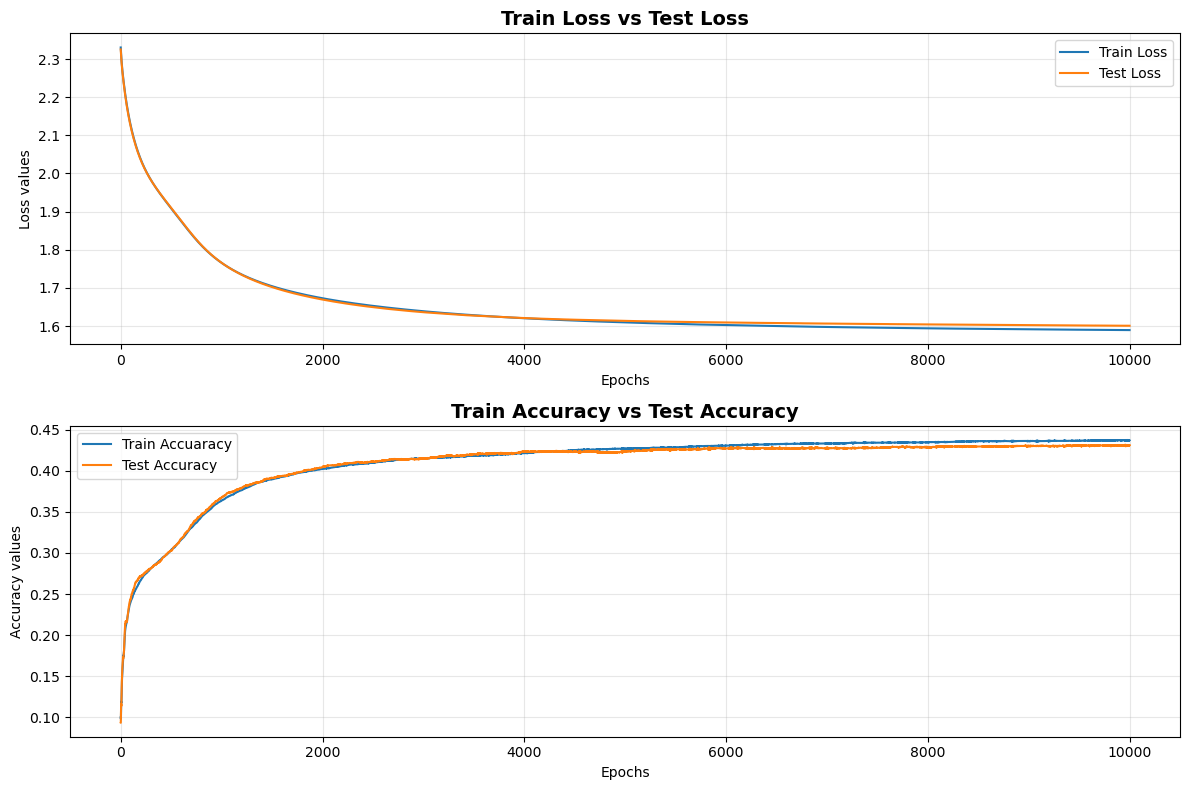

In [186]:
evaluate_model(model2_metrics2,y_test_tensor,test_preds22,class_names)

- model2_3
- number of cluster centers = 10
- learning rate = 0.1

In [187]:
epochs = 10000
kmeans = KMeans(n_clusters=10, random_state=42).fit(X_train_pca)
clusters = kmeans.cluster_centers_
model2_3 = mRBF_network2(clusters, len(class_names)).to(device)
model2_metrics3 = my_Metrics(epochs)

test_preds23 = train_test_model(model2_3,X_train_pca_tensor,y_train_tensor,X_test_pca_tensor,y_test_tensor,epochs,model2_metrics3,lr=0.1)

Epoch: 0 | Train Loss: 2.32632, Train Accuracy: 12.09% | Test Loss: 2.28306, Test Accuracy: 14.19%
Epoch: 1000 | Train Loss: 1.61728, Train Accuracy: 42.76% | Test Loss: 1.62244, Test Accuracy: 42.29%
Epoch: 2000 | Train Loss: 1.60564, Train Accuracy: 43.08% | Test Loss: 1.61474, Test Accuracy: 42.36%
Epoch: 3000 | Train Loss: 1.60056, Train Accuracy: 43.25% | Test Loss: 1.61182, Test Accuracy: 42.56%
Epoch: 4000 | Train Loss: 1.59718, Train Accuracy: 43.37% | Test Loss: 1.60983, Test Accuracy: 42.56%
Epoch: 5000 | Train Loss: 1.59461, Train Accuracy: 43.45% | Test Loss: 1.60819, Test Accuracy: 42.49%
Epoch: 6000 | Train Loss: 1.59265, Train Accuracy: 43.47% | Test Loss: 1.60653, Test Accuracy: 42.64%
Epoch: 7000 | Train Loss: 1.59089, Train Accuracy: 43.49% | Test Loss: 1.60533, Test Accuracy: 42.67%
Epoch: 8000 | Train Loss: 1.58938, Train Accuracy: 43.55% | Test Loss: 1.60404, Test Accuracy: 42.46%
Epoch: 9000 | Train Loss: 1.58823, Train Accuracy: 43.62% | Test Loss: 1.60321, Test 

              precision    recall  f1-score   support

    airplane       0.51      0.46      0.49      1000
  automobile       0.48      0.55      0.51      1000
        bird       0.32      0.30      0.31      1000
         cat       0.29      0.20      0.24      1000
        deer       0.37      0.29      0.33      1000
         dog       0.37      0.34      0.35      1000
        frog       0.42      0.56      0.48      1000
       horse       0.45      0.47      0.46      1000
        ship       0.51      0.59      0.54      1000
       truck       0.46      0.50      0.48      1000

    accuracy                           0.43     10000
   macro avg       0.42      0.43      0.42     10000
weighted avg       0.42      0.43      0.42     10000



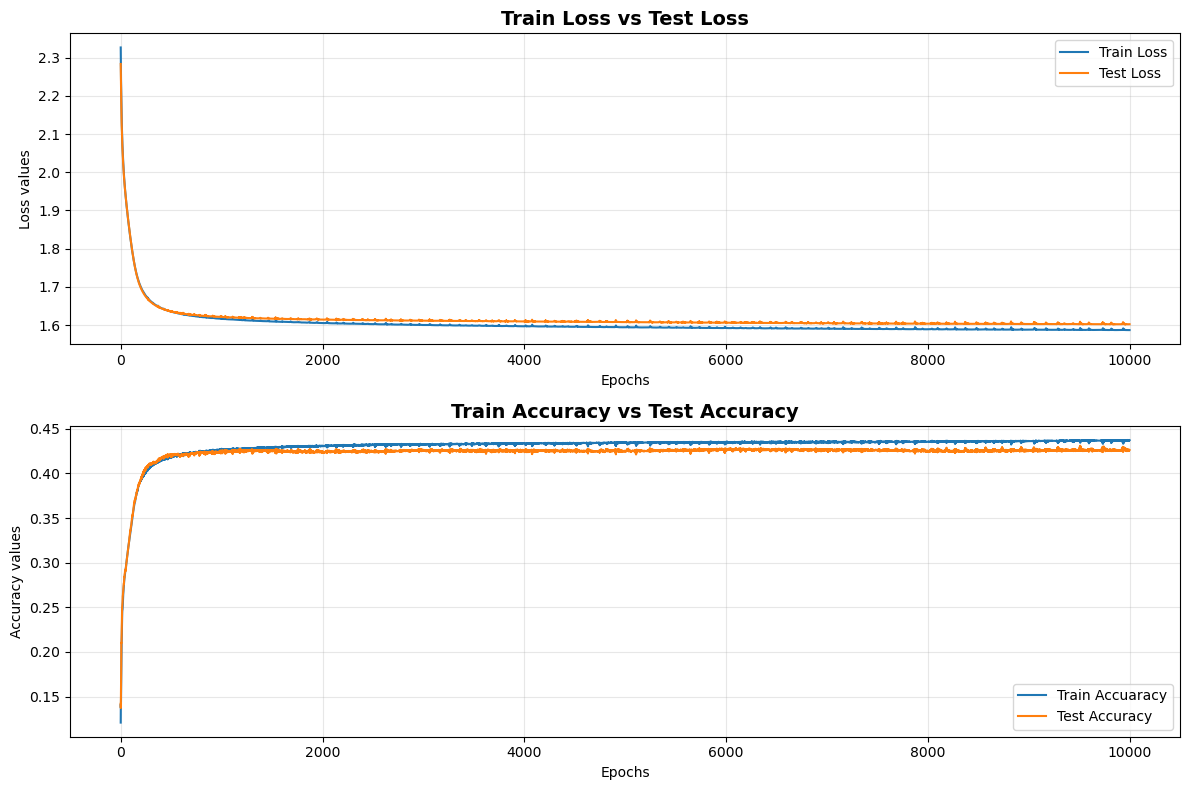

In [188]:
evaluate_model(model2_metrics3,y_test_tensor,test_preds23,class_names)

- model2_4
- number of cluster centers = 30
- learning rate = 0.1

In [189]:
kmeans = KMeans(n_clusters=30, random_state=42).fit(X_train_pca)
clusters = kmeans.cluster_centers_
epochs = 10000
model2_4 = mRBF_network2(clusters, len(class_names)).to(device)
model2_metrics4 = my_Metrics(epochs)

test_preds24 = train_test_model(model2_4,X_train_pca_tensor,y_train_tensor,X_test_pca_tensor,y_test_tensor,epochs,model2_metrics4,lr=0.1)

Epoch: 0 | Train Loss: 2.30748, Train Accuracy: 12.23% | Test Loss: 2.27713, Test Accuracy: 15.30%
Epoch: 1000 | Train Loss: 1.44649, Train Accuracy: 49.21% | Test Loss: 1.49327, Test Accuracy: 46.92%
Epoch: 2000 | Train Loss: 1.42210, Train Accuracy: 50.07% | Test Loss: 1.47584, Test Accuracy: 47.49%
Epoch: 3000 | Train Loss: 1.40897, Train Accuracy: 50.42% | Test Loss: 1.46687, Test Accuracy: 47.95%
Epoch: 4000 | Train Loss: 1.40003, Train Accuracy: 50.80% | Test Loss: 1.46080, Test Accuracy: 48.19%
Epoch: 5000 | Train Loss: 1.39389, Train Accuracy: 50.91% | Test Loss: 1.45667, Test Accuracy: 48.26%
Epoch: 6000 | Train Loss: 1.39212, Train Accuracy: 51.14% | Test Loss: 1.45826, Test Accuracy: 48.57%
Epoch: 7000 | Train Loss: 1.38408, Train Accuracy: 51.24% | Test Loss: 1.45036, Test Accuracy: 48.72%
Epoch: 8000 | Train Loss: 1.38103, Train Accuracy: 51.28% | Test Loss: 1.44906, Test Accuracy: 48.63%
Epoch: 9000 | Train Loss: 1.37783, Train Accuracy: 51.45% | Test Loss: 1.44651, Test 

              precision    recall  f1-score   support

    airplane       0.56      0.53      0.54      1000
  automobile       0.59      0.59      0.59      1000
        bird       0.38      0.34      0.36      1000
         cat       0.35      0.30      0.32      1000
        deer       0.42      0.35      0.38      1000
         dog       0.41      0.39      0.40      1000
        frog       0.47      0.60      0.53      1000
       horse       0.54      0.55      0.55      1000
        ship       0.58      0.64      0.61      1000
       truck       0.52      0.57      0.54      1000

    accuracy                           0.49     10000
   macro avg       0.48      0.49      0.48     10000
weighted avg       0.48      0.49      0.48     10000



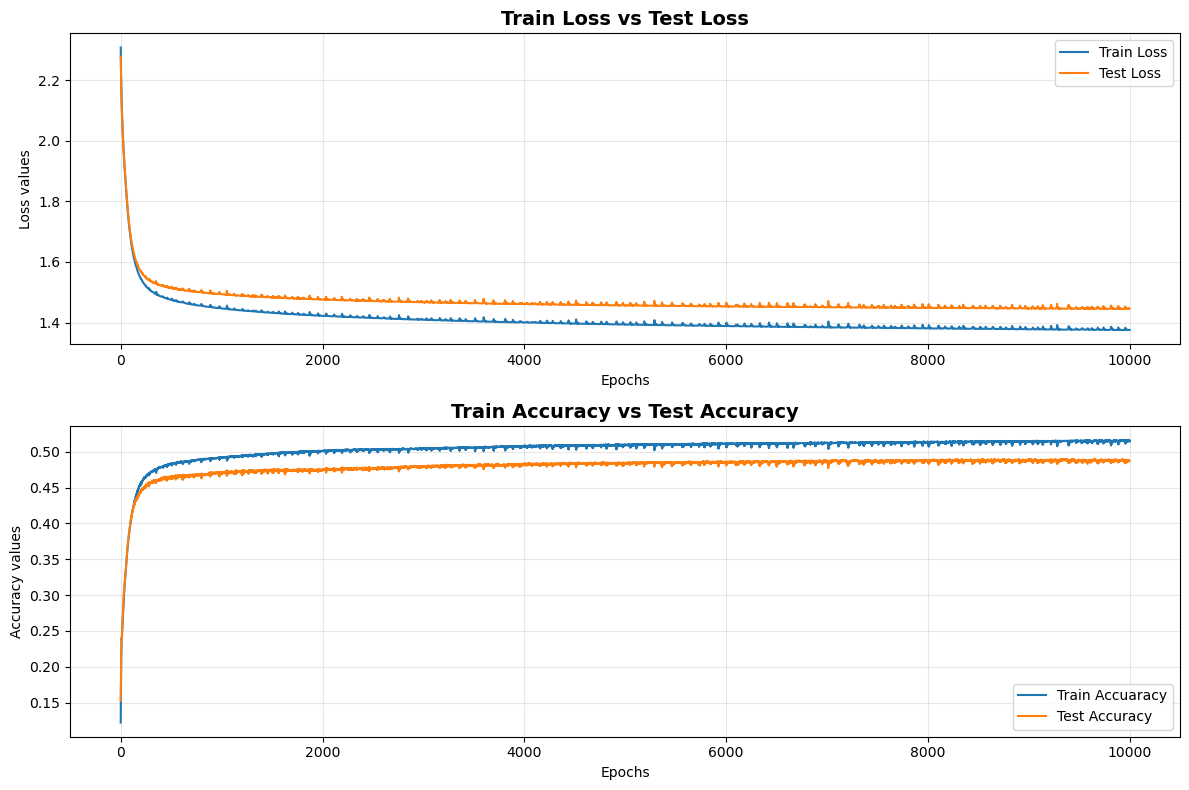

In [190]:
evaluate_model(model2_metrics4,y_test_tensor,test_preds24,class_names)  

- model2_5
- number of cluster centers = 20
- learning rate = 20

In [191]:
kmeans = KMeans(n_clusters=20, random_state=42).fit(X_train_pca)
clusters = kmeans.cluster_centers_
epochs = 10000
model2_5 = mRBF_network2(clusters, len(class_names)).to(device)
model2_metrics5 = my_Metrics(epochs)

test_preds25 = train_test_model(model2_5,X_train_pca_tensor,y_train_tensor,X_test_pca_tensor,y_test_tensor,epochs,model2_metrics5,lr=0.1)

Epoch: 0 | Train Loss: 2.31002, Train Accuracy: 10.77% | Test Loss: 2.27626, Test Accuracy: 11.57%
Epoch: 1000 | Train Loss: 1.50199, Train Accuracy: 47.35% | Test Loss: 1.53475, Test Accuracy: 45.81%
Epoch: 2000 | Train Loss: 1.48157, Train Accuracy: 48.13% | Test Loss: 1.52034, Test Accuracy: 46.45%
Epoch: 3000 | Train Loss: 1.47135, Train Accuracy: 48.47% | Test Loss: 1.51328, Test Accuracy: 46.86%
Epoch: 4000 | Train Loss: 1.46542, Train Accuracy: 48.73% | Test Loss: 1.50993, Test Accuracy: 47.13%
Epoch: 5000 | Train Loss: 1.45909, Train Accuracy: 48.94% | Test Loss: 1.50501, Test Accuracy: 47.13%
Epoch: 6000 | Train Loss: 1.45479, Train Accuracy: 49.07% | Test Loss: 1.50231, Test Accuracy: 47.29%
Epoch: 7000 | Train Loss: 1.45127, Train Accuracy: 49.18% | Test Loss: 1.50022, Test Accuracy: 47.30%
Epoch: 8000 | Train Loss: 1.44829, Train Accuracy: 49.26% | Test Loss: 1.49804, Test Accuracy: 47.31%
Epoch: 9000 | Train Loss: 1.44724, Train Accuracy: 49.23% | Test Loss: 1.49699, Test 

              precision    recall  f1-score   support

    airplane       0.53      0.53      0.53      1000
  automobile       0.52      0.57      0.55      1000
        bird       0.37      0.31      0.33      1000
         cat       0.35      0.29      0.32      1000
        deer       0.39      0.35      0.37      1000
         dog       0.42      0.36      0.39      1000
        frog       0.47      0.59      0.52      1000
       horse       0.52      0.52      0.52      1000
        ship       0.56      0.63      0.60      1000
       truck       0.51      0.54      0.52      1000

    accuracy                           0.47     10000
   macro avg       0.46      0.47      0.47     10000
weighted avg       0.46      0.47      0.47     10000



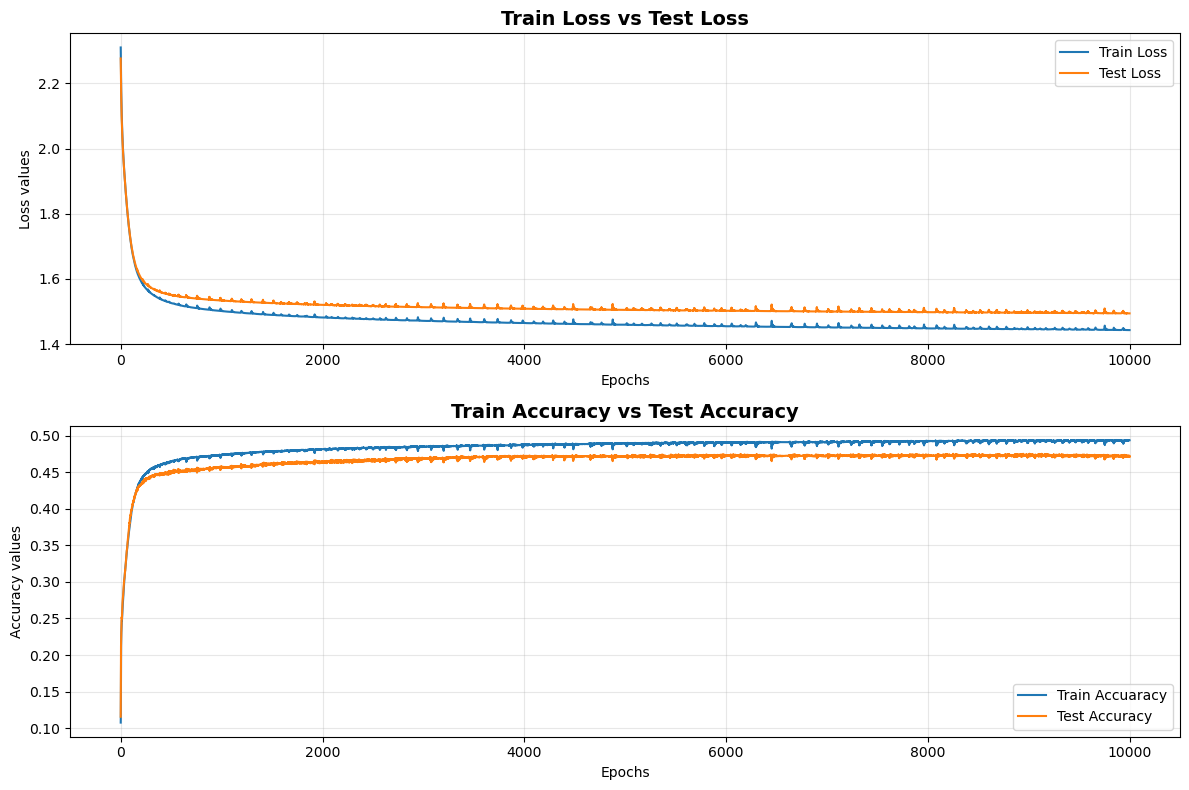

In [192]:
evaluate_model(model2_metrics5,y_test_tensor,test_preds25,class_names)

- model2_6
- number of cluster centers = 20
- learning rate = 1

In [193]:
kmeans = KMeans(n_clusters=10, random_state=42).fit(X_train_pca)
clusters = kmeans.cluster_centers_
epochs = 10000
model2_6 = mRBF_network2(clusters, len(class_names)).to(device)
model2_metrics6 = my_Metrics(epochs)

test_preds28 = train_test_model(model2_6,X_train_pca_tensor,y_train_tensor,X_test_pca_tensor,y_test_tensor,epochs,model2_metrics6,lr=1)

Epoch: 0 | Train Loss: 2.31925, Train Accuracy: 10.40% | Test Loss: 2.77840, Test Accuracy: 10.82%
Epoch: 1000 | Train Loss: 1.62374, Train Accuracy: 41.95% | Test Loss: 1.62885, Test Accuracy: 41.93%
Epoch: 2000 | Train Loss: 1.60955, Train Accuracy: 42.64% | Test Loss: 1.61763, Test Accuracy: 42.19%
Epoch: 3000 | Train Loss: 1.64001, Train Accuracy: 41.09% | Test Loss: 1.64479, Test Accuracy: 41.26%
Epoch: 4000 | Train Loss: 1.60911, Train Accuracy: 42.66% | Test Loss: 1.65416, Test Accuracy: 40.83%
Epoch: 5000 | Train Loss: 1.59507, Train Accuracy: 43.09% | Test Loss: 1.60592, Test Accuracy: 43.13%
Epoch: 6000 | Train Loss: 1.60575, Train Accuracy: 42.48% | Test Loss: 1.63005, Test Accuracy: 42.22%
Epoch: 7000 | Train Loss: 1.67454, Train Accuracy: 40.33% | Test Loss: 1.62980, Test Accuracy: 42.34%
Epoch: 8000 | Train Loss: 1.59942, Train Accuracy: 43.05% | Test Loss: 1.60551, Test Accuracy: 42.84%
Epoch: 9000 | Train Loss: 1.59746, Train Accuracy: 42.90% | Test Loss: 1.60492, Test 

- Plot the accuracy curves for the RBF NN(v2) models

From the following graph, i can say that training the clusters and σ leads to significantly higher accuracies compared to fixed clusters in the previous models (v1).

Also i notice that models with larg learing rates show high variance and instability in accuracy curves. On the other han smaller learning rates result in smoother convergence.

I can say that the increasing number of clusters improves perfomance. The top 4 models have 20 and 30 cluster centers instead of 10.

The following two models are the models with the highesst accuracy:
- `model2_r3` with 30 random cluster centers 
- `model2_4` with 30 cluster centers from the Kmeans algorithm

These models achieved roughly 48.7% accuracy

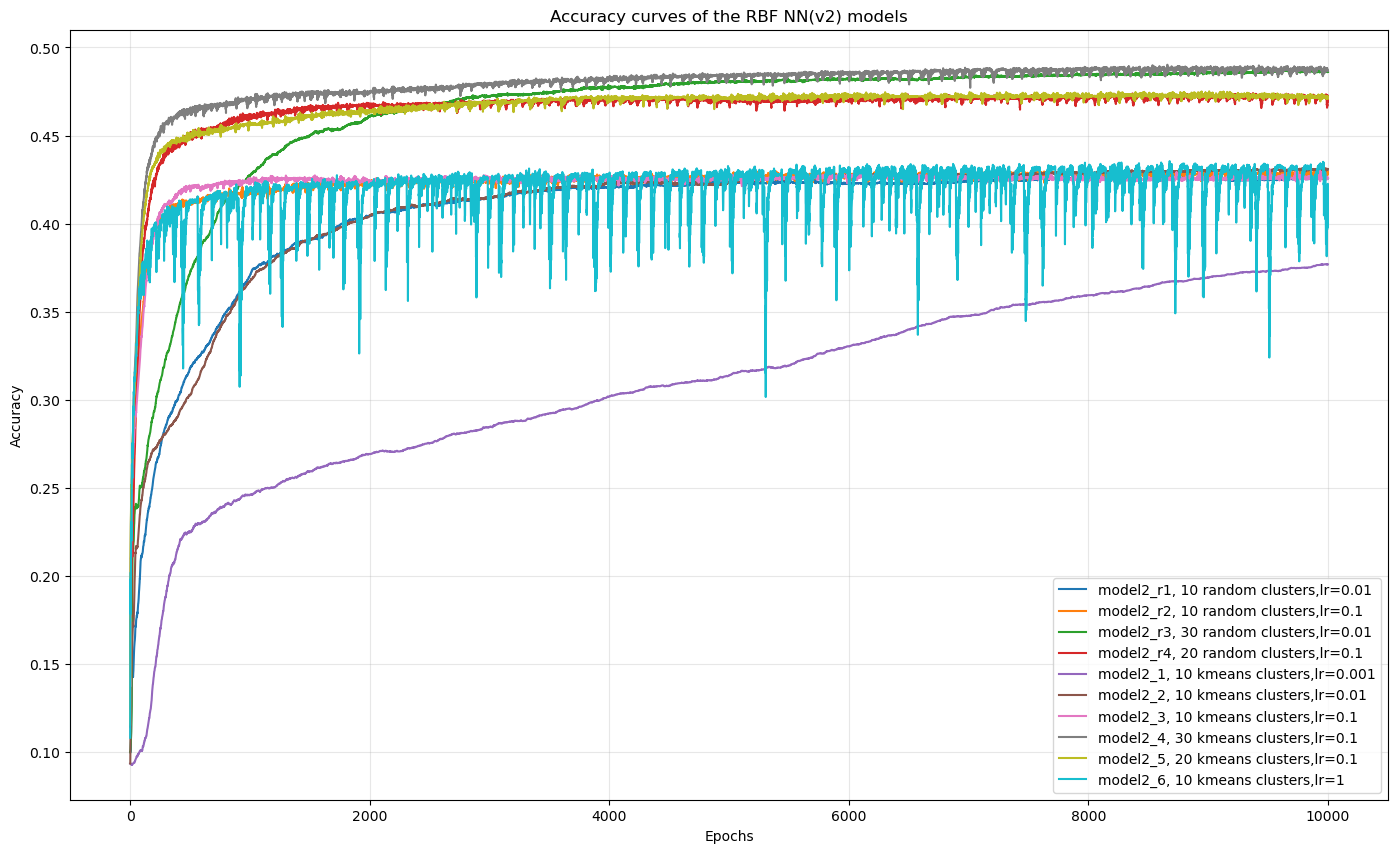

In [ ]:
plt.figure(figsize=(17, 10))
plt.plot(model2_r1_metrics.test_acc_values,label="model2_r1, 10 random clusters,lr=0.01");
plt.plot(model2_r2_metrics.test_acc_values,label="model2_r2, 10 random clusters,lr=0.1");
plt.plot(model2_r3_metrics.test_acc_values,label="model2_r3, 30 random clusters,lr=0.01");
plt.plot(model2_r4_metrics.test_acc_values,label="model2_r4, 20 random clusters,lr=0.1");
plt.plot(model2_metrics1.test_acc_values,label="model2_1, 10 kmeans clusters,lr=0.001");
plt.plot(model2_metrics2.test_acc_values,label="model2_2, 10 kmeans clusters,lr=0.01");
plt.plot(model2_metrics3.test_acc_values,label="model2_3, 10 kmeans clusters,lr=0.1");
plt.plot(model2_metrics4.test_acc_values,label="model2_4, 30 kmeans clusters,lr=0.1");
plt.plot(model2_metrics5.test_acc_values,label="model2_5, 20 kmeans clusters,lr=0.1");
plt.plot(model2_metrics6.test_acc_values,label="model2_6, 10 kmeans clusters,lr=1");

plt.grid(alpha=0.3)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy curves of the RBF NN(v2) models")
plt.legend();

## 3. Compare with KNN and NC

I will compare the perfomance of the RBF with the KNN classifier and the Nearest Centroid classifier.

I will also try to find the best hyperparameters for the KNN and NC classifiers with the GridSearchCV(), in order to achieve as high as possible accuracy.

### 3.1 Compare with KNN



In [195]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

knn = KNeighborsClassifier()
# Define the parameter grid
param_grid = {
    'n_neighbors': [3, 5, 7, 10],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'brute'],
    'leaf_size': [20, 30, 40],
    'metric': ['euclidean', 'minkowski']
}

#perform grid search
grid_search = GridSearchCV(knn, param_grid, cv=5, n_jobs=-1, verbose=1)
grid_search.fit(X_train_pca, y_train)

# Print the best parameters
print(f"Best parameters: {grid_search.best_params_}")

knn_best = grid_search.best_estimator_


Fitting 5 folds for each of 96 candidates, totalling 480 fits
Best parameters: {'algorithm': 'auto', 'leaf_size': 20, 'metric': 'euclidean', 'n_neighbors': 5, 'weights': 'distance'}


In [196]:
y_preds = knn_best.predict(X_test_pca)
knn_acc = accuracy_score(y_test, y_preds)
print(f"Best KNN accuracy: {knn_acc*100:.2f}%")
print(classification_report(y_test, y_preds, target_names=class_names))


Best KNN accuracy: 38.29%
              precision    recall  f1-score   support

    airplane       0.48      0.52      0.49      1000
  automobile       0.71      0.24      0.36      1000
        bird       0.27      0.41      0.32      1000
         cat       0.32      0.21      0.26      1000
        deer       0.26      0.53      0.35      1000
         dog       0.42      0.27      0.33      1000
        frog       0.34      0.43      0.38      1000
       horse       0.63      0.31      0.42      1000
        ship       0.42      0.68      0.52      1000
       truck       0.69      0.23      0.34      1000

    accuracy                           0.38     10000
   macro avg       0.45      0.38      0.38     10000
weighted avg       0.45      0.38      0.38     10000



###  Compare with Nearest Centroid

In [197]:
from sklearn.neighbors import NearestCentroid
nc = NearestCentroid()

param_grid = {
    'metric': ['euclidean', 'manhattan']
}

grid_search = GridSearchCV(nc, param_grid, cv=5, n_jobs=-1, verbose=1)

grid_search.fit(X_train_pca, y_train)

print(f"Best parameters: {grid_search.best_params_}")

best_nc = grid_search.best_estimator_


Fitting 5 folds for each of 2 candidates, totalling 10 fits
Best parameters: {'metric': 'manhattan'}


In [198]:
y_preds = best_nc.predict(X_test_pca)
nc_acc = accuracy_score(y_test, y_preds)
print(f"Best Nearest Centroid accuracy: {nc_acc*100:.2f}%")
print(classification_report(y_test, y_preds, target_names=class_names))

Best Nearest Centroid accuracy: 29.34%
              precision    recall  f1-score   support

    airplane       0.26      0.51      0.35      1000
  automobile       0.31      0.28      0.30      1000
        bird       0.24      0.10      0.14      1000
         cat       0.23      0.09      0.13      1000
        deer       0.32      0.18      0.23      1000
         dog       0.27      0.28      0.27      1000
        frog       0.26      0.44      0.32      1000
       horse       0.28      0.23      0.25      1000
        ship       0.41      0.42      0.41      1000
       truck       0.34      0.41      0.37      1000

    accuracy                           0.29     10000
   macro avg       0.29      0.29      0.28     10000
weighted avg       0.29      0.29      0.28     10000



From the above i can say that the RBF(v2) perfoms better than the KNN and a lot better than the NC. 

This makes sense because the RBF model is being trained (for a large number of epochs too), when the others 2 classifiers are not. 

This makes the model better as i saw, when the σ and the clusters were also trained along with the other parameters. That's why the mRBF_network2 models perform better than the mRBF_network1 models.

Also the RBF is a non linear model, when the KNN and the NC are, so it has the ability to process more complex data.

KNN also performs better than the Nearest Centroid classifier

## 4. Show 10 misclassified images

Last but not least, i will show 10 misclassified images for the best model i have found.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0047194707522893..2.282523957702424].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.3955118087505913..2.1224541071194976].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9203769221281155..1.7467845929916708].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6936025552469531..2.1605151960811586].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6109384707573944..1.8732415837119853].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9839828773304546..1.9088907849148462].
Clipping input data to 

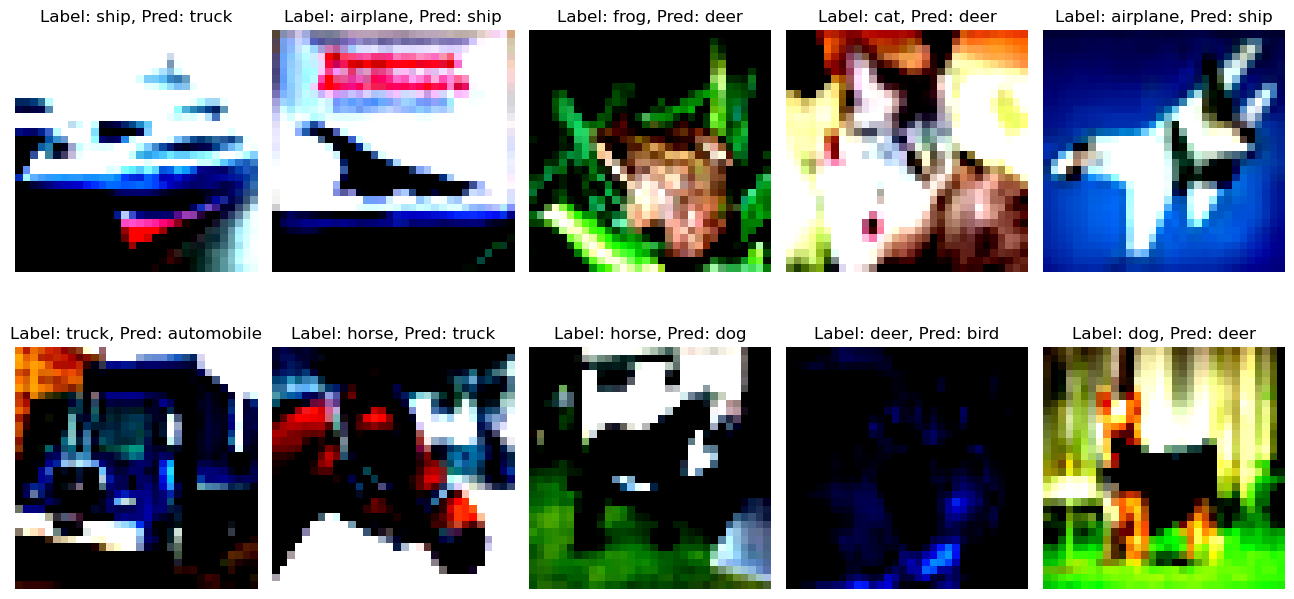

In [221]:
show_misclassified_images(model2_4, X_test_pca_tensor, y_test_tensor, class_names)